In [61]:
from PIL import Image
import h5py
import anubisPlotUtils as anPlot
import json
import numpy as np
import os
import hist as hi
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
matplotlib.use('TkAgg')  # or 'Qt5Agg', 'GTK3Agg', etc.
import mplhep as hep
hep.style.use([hep.style.ATLAS])
import sys
import ANUBIS_triggered_functions as ANT
import pandas as pd
import matplotlib.backends.backend_pdf
from matplotlib.ticker import MultipleLocator
import plotly
import plotly.graph_objs as go
import plotly.express as px
import csv 


%matplotlib inline

In [3]:
def check_event_attributes_by_RPC(event,min_chamber_number,min_RPC_number,RPC_excluded):
    #Used in filter_events() function to decide whether or not to save an event as described by the user's inputs.
    #The user selects an RPC to exclude from the filter. 
    #e.g. say we want to exclude RPC 4 and the user selects a min_RPC_number of 4. The check_event_...() will check if the
    #event has atleast 4 RPCs hit.

    #USING ONLY ETA FILTER HERE SINCE THIS IS WHAT TRIGGERS THE CHANNEL!

    # event = ['Event x',TIMEBIN, [[[RPC1_PHI_CLUSTERS],[RPC1_ETA_CLUSTERS]],[[...],[...]],...]

    RPC_counter = 0
    chamber_counter = 0
    condition_1 = False
    condition_2 = False
    condition_3 = False

    for RPC in range(6):

        if RPC ==  RPC_excluded:
            pass
        else:
            if RPC<3:
                #Checking triplet layer.
                if event[2][RPC][1]:
                    #Reqiure atleast one eta strip to go off
                    RPC_counter+=1 
                    #If RPC has two eta and phi strips going off then consider it "hit"
                    if not condition_1:
                        #Count triplet chamber being hit.
                        chamber_counter+=1
                        condition_1 = True
            elif RPC == 3:
                #Singlet layer
                if event[2][RPC][1]:
                    RPC_counter+=1
                    if not condition_2:
                        chamber_counter+=1
                        condition_2 = True
            else:
                #Doublet layer
                if event[2][RPC][1]:
                    RPC_counter+=1
                    if not condition_3:
                        chamber_counter+=1
                        condition_3 = True
    return RPC_counter >= min_RPC_number and chamber_counter >= min_chamber_number

def filter_events_by_RPC(events,min_chamber_number,min_RPC_number,RPC_excluded):
    #Initiliase array of filtered events
    filtered_events = []

    for event in events:
        if check_event_attributes_by_RPC(event,min_chamber_number,min_RPC_number,RPC_excluded):
            filtered_events.append(event)

   # print(f"Number of events in filter = {len(filtered_events)}")
    
    return filtered_events

def reconstruct_timed_byRPC(event,max_cluster_size,RPC_excluded):

    #timed tag indicates that timing information from RPC is used to determine direction of vertical transversal of "particle" in the event.

    max_residual = 100

    # event = ['Event x',TIMEBIN, [[[RPC1_PHI_CLUSTERS],[RPC1_ETA_CLUSTERS]],[[...],[...]],...]
    RPC_heights = [0.6,1.8,3.0,61.8,121.8,123] #Heights of middle point of each RPC, measured from the bottom of the Triplet Low RPC. Units are cm.

    #Extract x and y coords of cluster in event

    coords = ANT.extract_coords_timed(event,max_cluster_size)
    #print(coords)

    #UPDATE COORDS TO IGNORE THE RPC UNDER TEST

    test_coords = coords[RPC_excluded]
    coords[RPC_excluded] = [[],[],"N"]

    dT = ANT.extract_DT(coords)

    #print(coords)

    if dT is None:
        #print("Failed to reconstruct, dT is NoneType")
        return None

    # Count the number of empty RPCs
    empty_RPC_count = sum(1 for item in coords if item == [[], [],'N'])

    # If less than 3 elements of coords are occupied, exit the function
    if empty_RPC_count > 3:
        #print("Failed to reconstruct, not enough coords")
        return None  # Exit the function

    #ITERATING OVER EVERY POSSIBLE COMBINATION OF x,y,z over all 3 RPCs (limited to one x,y per RPC).
    #Doesn't look particularly nice, but there are not many coordinates to loop over usually....

    combinations = ANT.generate_hit_coords_combo(coords,RPC_heights)

    #Now for each combo in combinations, attempt to reconstruct a path. See which one gives the best trajectory.

    #If success, print parameters of fitting function.
    #If fail, print reconstruction failed.

    residuals_current = np.inf
    optimised_coords = None
    optimised_d= None
    optimised_centroid= None

    for ind,combo in enumerate(combinations):

        centroid, d, residuals = ANT.fit_event(combo)
        if residuals < residuals_current:

            # If new fit is better than old then replace old fit.
            residuals_current = residuals
            optimised_centroid = centroid
            optimised_d = d
            optimised_coords = combinations[ind]

    #if dT>0 this implies the particles hit the higher RPC after the lower one, so the particle is travelling upwards here.
    #Vice-versa for dT < 0.

    #dT = 0 case?
    
    if dT > 0:
        if optimised_d[2] < 0:
            optimised_d = np.multiply(optimised_d,-1)
    else:
        if optimised_d[2] > 0:
            optimised_d = np.multiply(optimised_d,-1)

    if residuals_current<max_residual:
        return optimised_centroid, optimised_d, optimised_coords, combinations, residuals_current, dT, test_coords
    else:
        #print("Failed to reconstruct, residuals too large")
        #return optimised_centroid, optimised_d, optimised_coords, combinations, residuals_current
        return None
    
def does_RPC_detect_muon(muon_coords,test_coords,tol):
    #Tolerance in units of cm. 

    #Could experiment with tolerance.

   # print(test_coords)

    if test_coords != [[],[],"N"]: 

        t = test_coords[:-1]# Doing this because .pop() seems to act globally...

        for x in t[0]:
            for y in t[1]:

                #print([x,y])
                #If statement ensures only calculate the coords if the test_coords actually exist.

                #Offset is 2D vector that represents difference 
                offset = np.subtract(np.array([x,y]),muon_coords)

                separation = np.linalg.norm(offset)

                #print(separation)

                if separation <= tol:
                    #Say the RPC only successfully reconstructs an event 
                    #if the distance between expected hit and reconstructed hit is less than tolerance.

                    #print("RPC successfully detects hit!")
                    return separation
        
        #print("No RPC coordinates constructed pass near the expected point!")
        return False

    else:
        #print("No coordinates reconstructed by RPC")
        return False

def does_muon_hit_RPC(optimised_centroid, optimised_d, RPC):

    RPC_heights = [0.6,1.8,3.0,61.8,121.8,123] 
    #Heights of middle point of each RPC, measured from the bottom of the Triplet Low RPC. Units are cm.

    # x_bar = x_centroid + d_vector * t
    # Find value of paramter t when the muon trajectory passes through the RPC height.
    
    z_0 = optimised_centroid[2]
    z = RPC_heights[RPC]

    # t = (z-z_0)/d_z

    t = (z-z_0)/optimised_d[2]

    # Find expected (x,y) coordinates at that height.

    x = optimised_centroid[0] + t*optimised_d[0]
    y = optimised_centroid[1] + t*optimised_d[1]

    # Check if these (x,y) coordinates lie within the RPC. 

    #Extract x and y coords of cluster in event
    distance_per_phi_channel = 2.7625 #cm
    distance_per_eta_channel = 2.9844 #cm

    # Max y (eta side) is 31.5 * distance_per_eta_channel
    # Max x (phi side) is 63.5 * distance_per_phi_channel

    if 0 < x < 63.5*distance_per_phi_channel and 0 < y < 31.5*distance_per_eta_channel:
        #Return coordinates where you expect the muon to hit this RPC from the reconstructed event.
        return [x,y]
    else:
        #print("Muon does not hit RPC")
        return None   

def calc_efficiency_RPC(dataset,RPC,tol):
    # RPC input is number 0 to 5.
    # dataset is output of ANT.cluser()
    # tol is tolerance on checkHit in cm.

    events = filter_events_by_RPC(dataset,2,5,RPC)

    possible_reconstructions = 0
    successful_reconstructions = 0

    for i,event in enumerate(events):

        #print(f"Event index {i}")

        E_recon = reconstruct_timed_byRPC(event,3,RPC)

        if E_recon:

            if len(E_recon[2])>=5:
                #Adding this check to see if other 5 RPCs are in reconstructed event.
                #This is necessary to ensure the reconstructed path is accurate.

                muon_coords = does_muon_hit_RPC(E_recon[0],E_recon[1],RPC)

                if muon_coords:

                    possible_reconstructions+=1 

                    check = does_RPC_detect_muon(muon_coords,E_recon[6],tol)

                    if check:
                        successful_reconstructions+=1 

    print(possible_reconstructions)
    print(successful_reconstructions)

    return successful_reconstructions/possible_reconstructions

In [4]:
current_directory=  os.path.dirname(os.getcwd())

data = ANT.importDatafile(current_directory+"\\ProAnubisData\\ATLAS LUMINOSITY\\proAnubis_240403_0227.h5")

TEST w/ OLD FUNCTION

In [5]:
data_ATLAS = [sublist[:94230] for sublist in data]
etaHits, phiHits = ANT.divideHitCountsByRPC_Timed(data_ATLAS)

In [6]:
print(phiHits[5][172])
print(etaHits[5][172])

[[], [], [], [], [], [], [], [], [851851], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [254], [], [], [], [], [], [], [], [], [], [], [], [], []]


In [7]:
print(len(phiHits[0]))

94230


^ CORRUPTED DATA PRESENT HERE!

FUNCTION TO FILTER

In [95]:
def countChannels_Timed_UNCORRUPTED(events):
    #Expects events from one TDC, counts how many hits each channel has within the event list

    chanCounts = [[] for x in range(128)]
    number_corruptions = 0

    for event in events:
        for word in event:
            #get time of event
            time = word&0xfffff

            #ADD CHECK TO SEE THAT DATA IS NOT CORRUPTED 
            if 0 <= time <= 1250:
                try:
                    #Append time of event to specific channel triggered to get event.
                    chanCounts[(word>>24)&0x7f].append(time)
                except:
                    print(word>>24)
            else:
                number_corruptions+=1
                print(f"HERE:{time}")
                chanCounts[(word>>24)&0x7f].append("CORRUPT")
    return chanCounts, number_corruptions

def divideHitCountsByRPC_Timed_UNCORRUPTED(data):
    #Divides the number of hits in each channel into individual RPCs
    etaHits = [[],[],[],[],[],[]]
    phiHits = [[],[],[],[],[],[]]
    number_corruptions= []
    tdc_corruptions = [0,0,0,0,0]

    for event in range(0,len(data[0])):

        event_corruptions = 0
        
        tdcCounts = []
        for tdc in range(5):
            chanCounts, n_corruptions = countChannels_Timed_UNCORRUPTED([data[tdc][event]])
            if n_corruptions == 0:
                tdcCounts.append(chanCounts)
            else:
                event_corruptions += n_corruptions
                tdc_corruptions[tdc] += n_corruptions

        #ONLY APPEND EVENT IF IT DOES NOT INCLUDE CORRUPTED DATA

        print(len(tdcCounts))
        
        if len(tdcCounts) == 5:
            #No corrupted events

            etaHits[0].append(tdcCounts[0][0:32]) #Triplet Eta Low
            phiHits[0].append(tdcCounts[0][32:96]) #Triplet Phi low
            etaHits[1].append(tdcCounts[0][96:128]) #Triplet Eta Mid
            phiHits[1].append(tdcCounts[1][0:64]) #Triplet Phi Mid
            etaHits[2].append(tdcCounts[1][64:96]) #Triplet Eta Top
            phiHits[2].append(tdcCounts[1][96:128]+tdcCounts[2][0:32]) #Triplet Phi Top
            etaHits[3].append(tdcCounts[2][32:64])#Singlet Eta
            phiHits[3].append(tdcCounts[2][64:128])#Singlet Phi
            etaHits[4].append(tdcCounts[3][0:32])#Double Eta low
            phiHits[4].append(tdcCounts[3][32:96])#Double Phi Low
            etaHits[5].append(tdcCounts[3][96:128])#Doublet Eta top
            phiHits[5].append(tdcCounts[4][0:64])#Doublet Phi top

        else:
            
            print(f"Corrupted Event, {event_corruptions} corrupted events")
            number_corruptions.append(event_corruptions)
    

    return etaHits,phiHits,number_corruptions, tdc_corruptions

FILTER EVENTS W/ CORRUPTED TIME HITS

In [96]:
etaHits_uc, phiHits_uc, number_corruptions, tdc_corruptions = divideHitCountsByRPC_Timed_UNCORRUPTED(data_ATLAS)

5
HERE:1285
4
Corrupted Event, 1 corrupted events
5
5
HERE:1519
HERE:549340
HERE:549394
3
Corrupted Event, 3 corrupted events
5
5
HERE:738913
HERE:738917
4
Corrupted Event, 2 corrupted events
5
HERE:439218
HERE:439269
HERE:439365
4
Corrupted Event, 3 corrupted events
5
HERE:1356
HERE:1401
4
Corrupted Event, 2 corrupted events
5
5
5
HERE:753483
HERE:753530
4
Corrupted Event, 2 corrupted events
5
HERE:1270
HERE:1322
HERE:1324
HERE:1323
HERE:1318
HERE:1312
HERE:1311
HERE:1256
HERE:1304
HERE:1303
HERE:1299
HERE:1295
4
Corrupted Event, 12 corrupted events
5
HERE:1539
HERE:1574
4
Corrupted Event, 2 corrupted events
5
5
HERE:960296
HERE:960394
4
Corrupted Event, 2 corrupted events
HERE:1302
HERE:202020
HERE:202064
HERE:202151
3
Corrupted Event, 4 corrupted events
5
5
5
5
5
5
5
5
5
5
5
HERE:1512
HERE:1558
HERE:1554
HERE:1006199
HERE:1006201
HERE:1006198
HERE:1006197
HERE:1006197
HERE:1006199
HERE:1006198
HERE:1006199
HERE:1007507
HERE:1007557
HERE:1007652
2
Corrupted Event, 14 corrupted events

In [100]:
print(tdc_corruptions)

[849, 2935, 8716, 15386, 97062]


In [109]:
sum_error = np.sum(tdc_corruptions)
print(sum_error)

124948


In [110]:
print(np.sum(number_corruptions))

124948


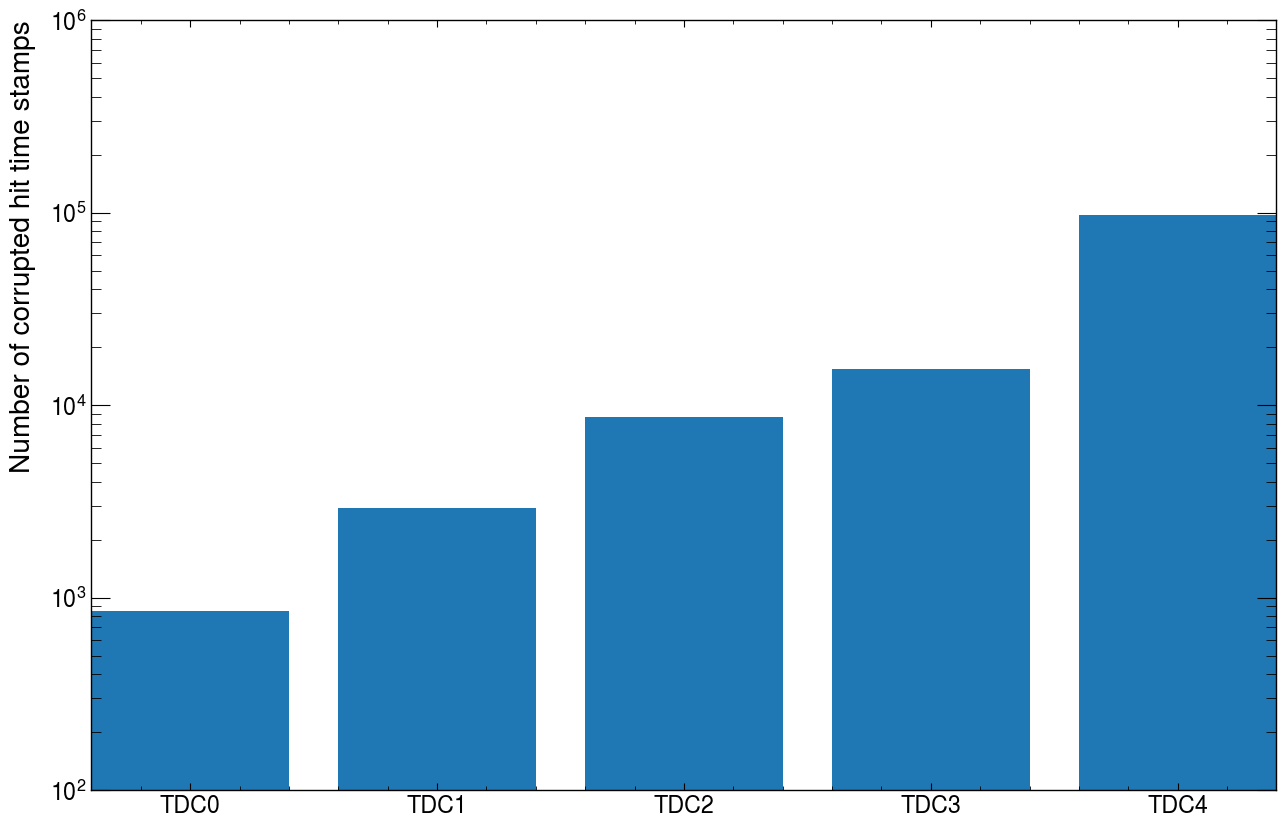

In [108]:
x_marks = ['TDC0','TDC1','TDC2','TDC3','TDC4']

plt.figure(figsize=(15,10))

plt.bar(x_marks,tdc_corruptions)
plt.ylabel('Number of corrupted hit time stamps')
plt.yscale('log')

plt.show()

In [51]:
print(phiHits_uc[0][172])
print(etaHits_uc[0][172])

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [247], [243], [246], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [259], [259], [260], [], [], [], [], []]


Corrupted data gone ^

In [97]:
print(len(phiHits_uc[0]))

62993


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


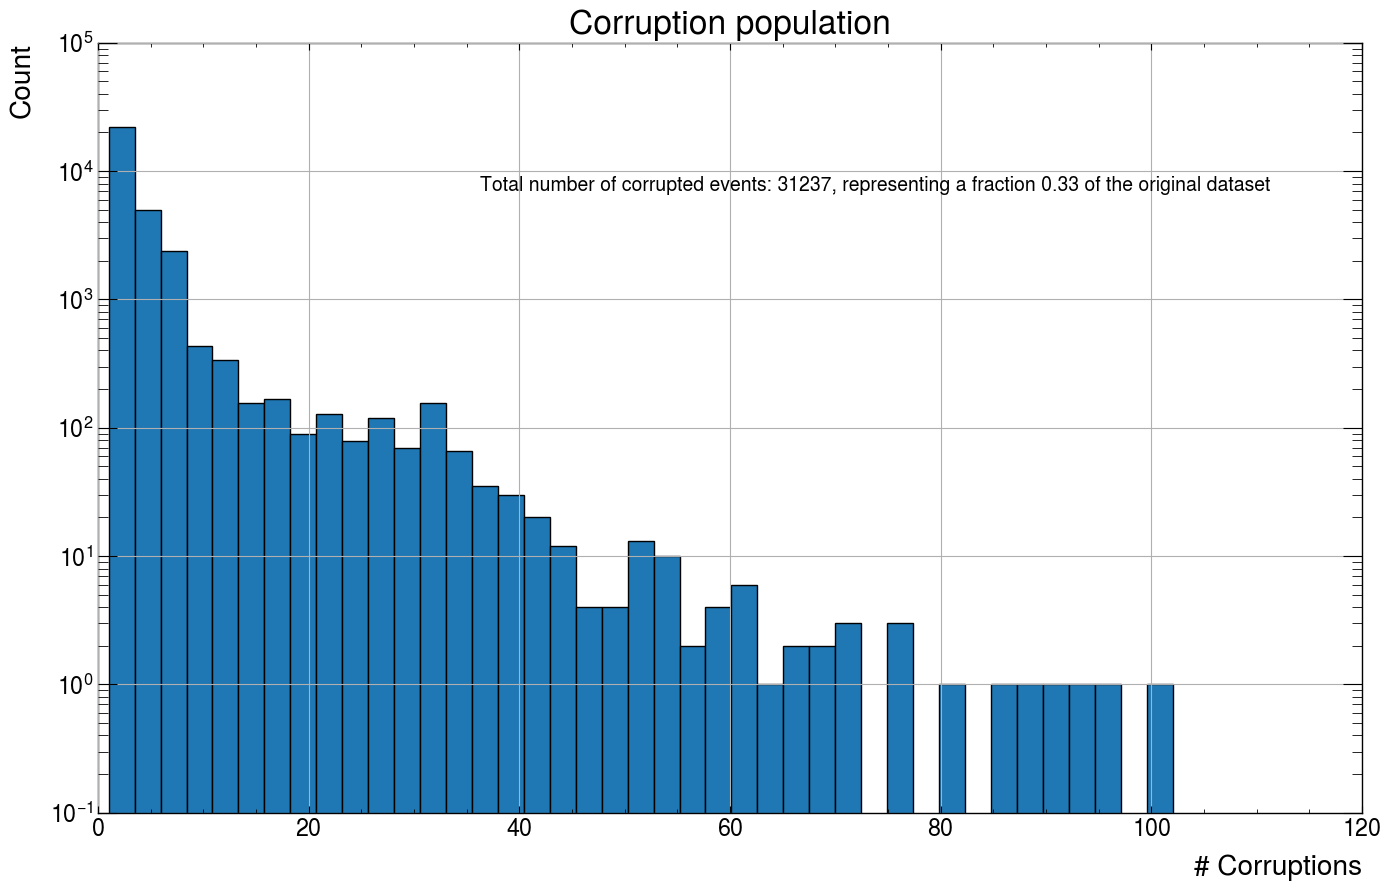

In [57]:
plt.figure(figsize=(16, 10))

# Plot histogram with counts
plt.hist(number_corruptions, bins=41, density=False, edgecolor='black')

# # Set x-ticks spacing to 1
# plt.xticks(np.arange(-20, 21, 2))

plt.annotate(f"Total number of corrupted events: {len(phiHits[0])-len(phiHits_uc[0])}, representing a fraction {(len(phiHits[0])-len(phiHits_uc[0]))/len(phiHits[0]):.2f} of the original dataset",(0.3,0.7),xycoords='figure fraction')

# Customize the plot
plt.xlabel('# Corruptions')
plt.ylabel('Count')
plt.title("Corruption population")
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

Removing Corrupted Events leaves 77900/94230, leaving 82% of the original data set. 

In [58]:
#Time_window for coincidence set at 15 ns.
#Temporal Clustering
coincident_hits_ATLAS = ANT.FindCoincidentHits(etaHits_uc,phiHits_uc,15)

#Spatial Clustering
coincident_hits_ATLAS_clustered = ANT.cluster(coincident_hits_ATLAS)

0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1

In [59]:
print(len(coincident_hits_ATLAS_clustered))

132375


0.0
725
0
0.40816326530612246
725
125
0.8163265306122449
725
255
1.2244897959183674
725
359
1.6326530612244898
725
437
2.0408163265306123
725
487
2.4489795918367347
725
511
2.857142857142857
725
523
3.2653061224489797
725
525
3.673469387755102
725
526
4.081632653061225
725
527
4.4897959183673475
725
528
4.8979591836734695
725
528
5.3061224489795915
725
528
5.714285714285714
725
528
6.122448979591837
725
528
6.530612244897959
725
528
6.938775510204081
725
529
7.346938775510204
725
529
7.755102040816327
725
529
8.16326530612245
725
529
8.571428571428571
725
529
8.979591836734695
725
529
9.387755102040817
725
529
9.795918367346939
725
529
10.204081632653061
725
529
10.612244897959183
725
529
11.020408163265307
725
529
11.428571428571429
725
529
11.83673469387755
725
529
12.244897959183675
725
529
12.653061224489797
725
529
13.061224489795919
725
529
13.46938775510204
725
529
13.877551020408163
725
529
14.285714285714286
725
529
14.693877551020408
725
529
15.10204081632653
725
529
15.51020

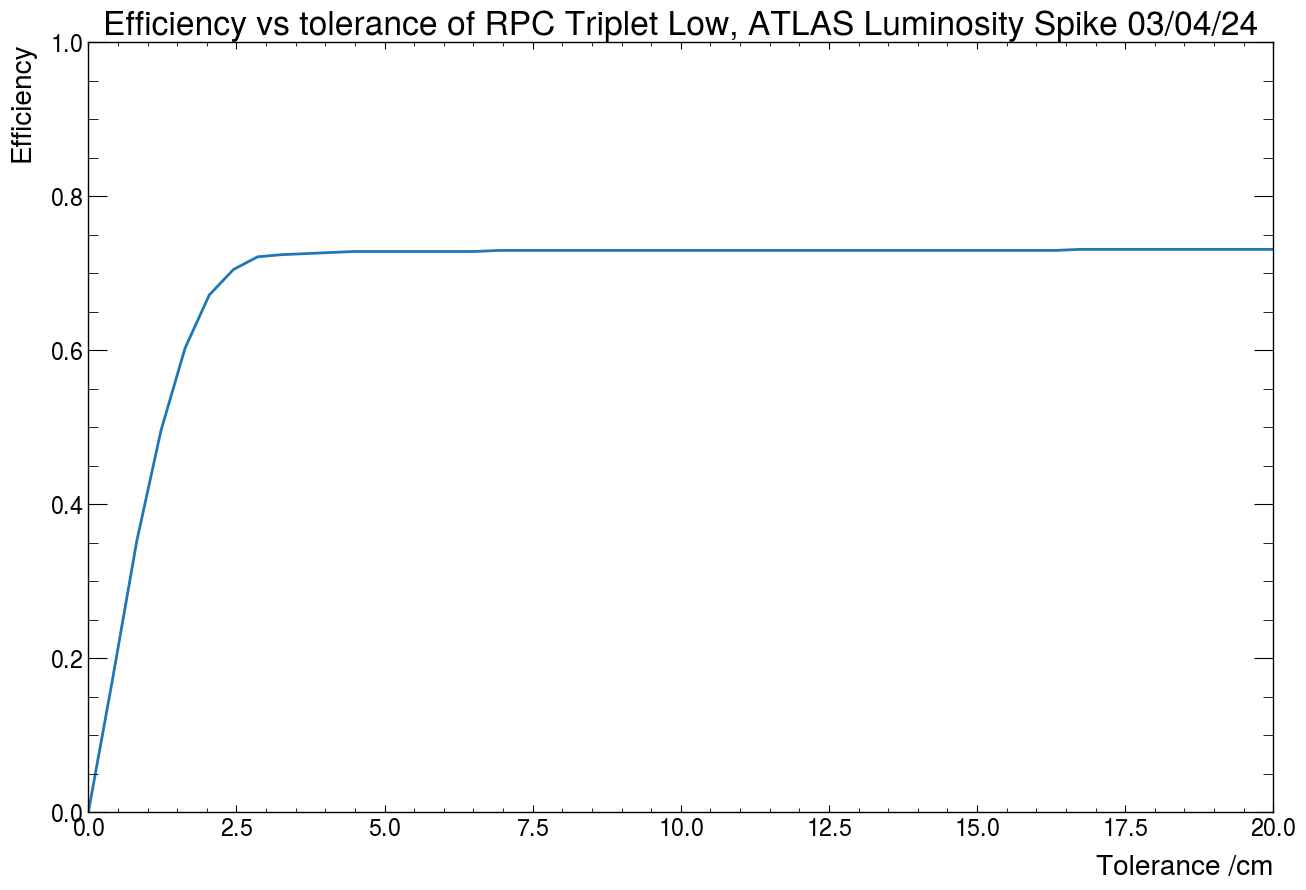

In [88]:
tolerances = np.linspace(0,20,50)

efficiencies1 = []

for tol in tolerances:
    print(tol)
    efficiencies1.append(calc_efficiency_RPC(coincident_hits_ATLAS_clustered,0,tol))

# Zip the nested lists together
toWrite = zip(efficiencies1, tolerances)

with open('TripletLow.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerows(toWrite)

plt.figure(figsize=(15,10))

plt.plot(tolerances, efficiencies1)
plt.xlabel('Tolerance /cm')
plt.ylabel('Efficiency')
plt.ylim(0,1)

plt.title('Efficiency vs tolerance of RPC Triplet Low, ATLAS Luminosity Spike 03/04/24')

plt.show()

0.0
650
0
0.40816326530612246
650
90
0.8163265306122449
650
193
1.2244897959183674
650
301
1.6326530612244898
650
396
2.0408163265306123
650
446
2.4489795918367347
650
497
2.857142857142857
650
515
3.2653061224489797
650
524
3.673469387755102
650
532
4.081632653061225
650
533
4.4897959183673475
650
533
4.8979591836734695
650
533
5.3061224489795915
650
534
5.714285714285714
650
534
6.122448979591837
650
534
6.530612244897959
650
534
6.938775510204081
650
534
7.346938775510204
650
534
7.755102040816327
650
534
8.16326530612245
650
534
8.571428571428571
650
534
8.979591836734695
650
534
9.387755102040817
650
534
9.795918367346939
650
534
10.204081632653061
650
534
10.612244897959183
650
534
11.020408163265307
650
534
11.428571428571429
650
534
11.83673469387755
650
534
12.244897959183675
650
534
12.653061224489797
650
534
13.061224489795919
650
534
13.46938775510204
650
534
13.877551020408163
650
534
14.285714285714286
650
534
14.693877551020408
650
534
15.10204081632653
650
534
15.510204

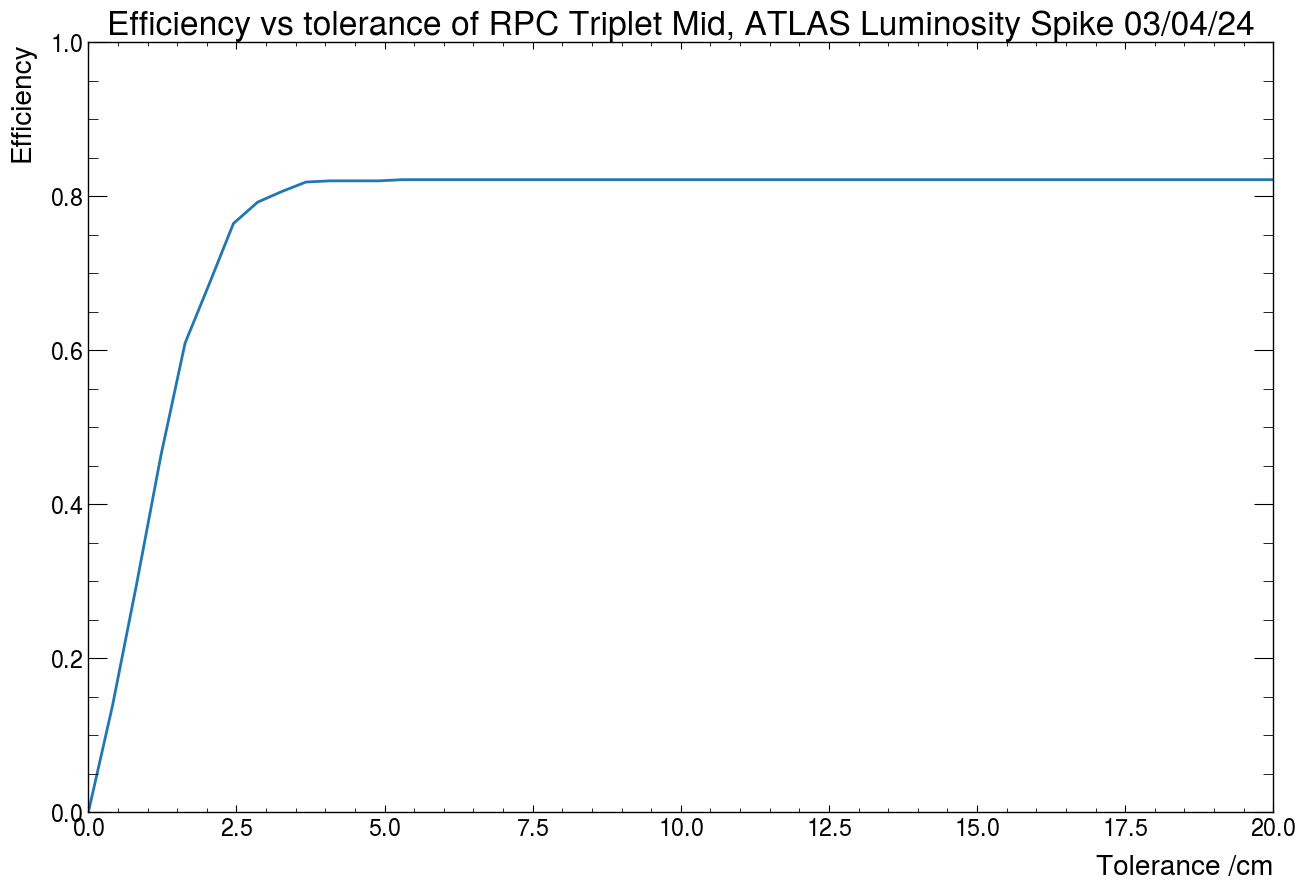

In [89]:
tolerances = np.linspace(0,20,50)

efficiencies2 = []

for tol in tolerances:
    print(tol)
    efficiencies2.append(calc_efficiency_RPC(coincident_hits_ATLAS_clustered,1,tol))

# Zip the nested lists together
toWrite = zip(efficiencies2, tolerances)

with open('TripletMid.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerows(toWrite)

plt.figure(figsize=(15,10))

plt.plot(tolerances, efficiencies2)
plt.xlabel('Tolerance /cm')
plt.ylabel('Efficiency')
plt.ylim(0,1)

plt.title('Efficiency vs tolerance of RPC Triplet Mid, ATLAS Luminosity Spike 03/04/24')

plt.show()

0.0
764
0
0.40816326530612246
764
54
0.8163265306122449
764
220
1.2244897959183674
764
362
1.6326530612244898
764
439
2.0408163265306123
764
489
2.4489795918367347
764
517
2.857142857142857
764
523
3.2653061224489797
764
528
3.673469387755102
764
528
4.081632653061225
764
530
4.4897959183673475
764
530
4.8979591836734695
764
531
5.3061224489795915
764
533
5.714285714285714
764
533
6.122448979591837
764
533
6.530612244897959
764
533
6.938775510204081
764
533
7.346938775510204
764
533
7.755102040816327
764
533
8.16326530612245
764
533
8.571428571428571
764
533
8.979591836734695
764
533
9.387755102040817
764
533
9.795918367346939
764
533
10.204081632653061
764
533
10.612244897959183
764
533
11.020408163265307
764
533
11.428571428571429
764
533
11.83673469387755
764
533
12.244897959183675
764
533
12.653061224489797
764
534
13.061224489795919
764
534
13.46938775510204
764
534
13.877551020408163
764
535
14.285714285714286
764
535
14.693877551020408
764
535
15.10204081632653
764
535
15.510204

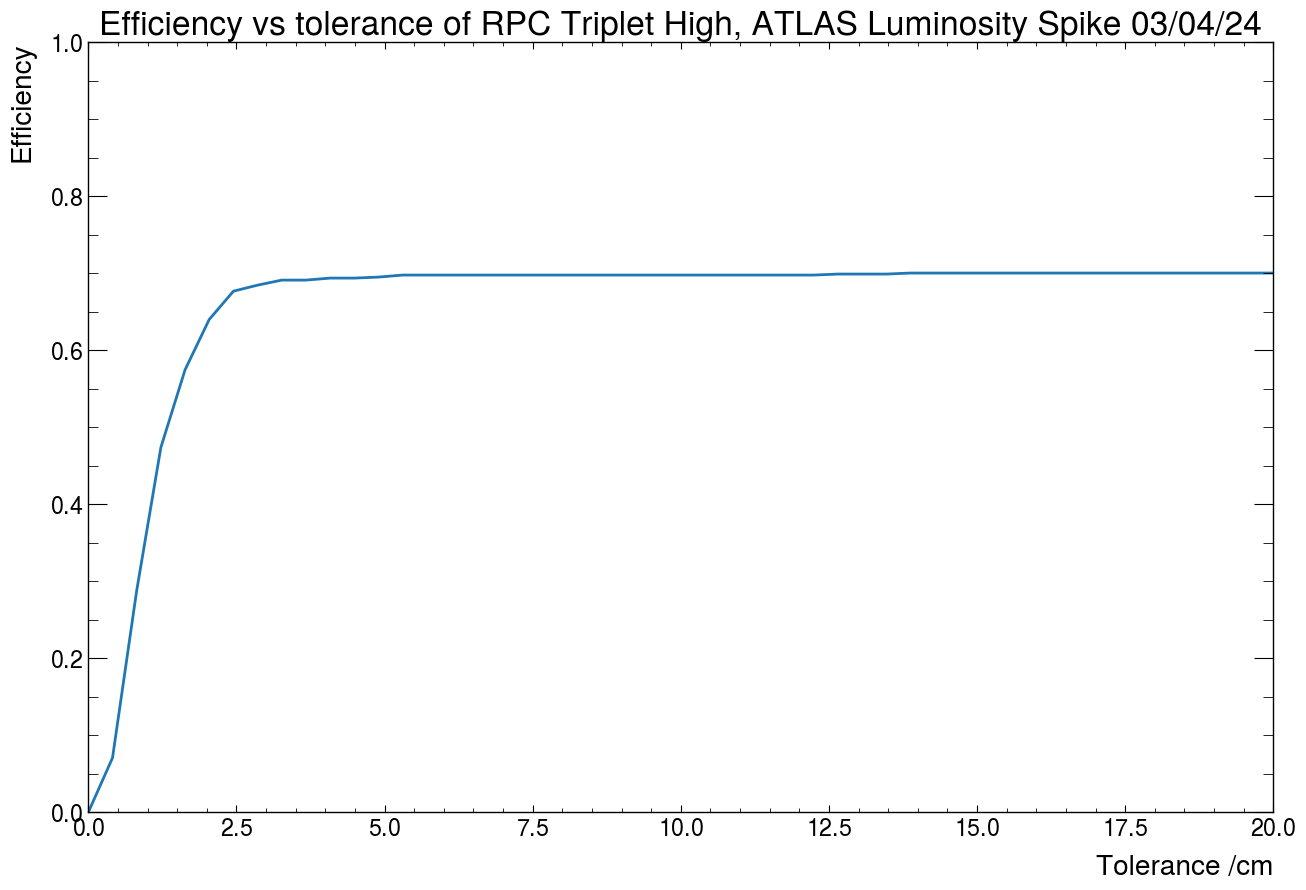

In [90]:
tolerances = np.linspace(0,20,50)

efficiencies3 = []

for tol in tolerances:
    print(tol)
    efficiencies3.append(calc_efficiency_RPC(coincident_hits_ATLAS_clustered,2,tol))

# Zip the nested lists together
toWrite = zip(efficiencies3, tolerances)

with open('TripletTop.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerows(toWrite)

plt.figure(figsize=(15,10))

plt.plot(tolerances, efficiencies3)
plt.xlabel('Tolerance /cm')
plt.ylabel('Efficiency')
plt.ylim(0,1)

plt.title('Efficiency vs tolerance of RPC Triplet High, ATLAS Luminosity Spike 03/04/24')

plt.show()

0.0
756
0
0.40816326530612246
756
24
0.8163265306122449
756
50
1.2244897959183674
756
95
1.6326530612244898
756
174
2.0408163265306123
756
254
2.4489795918367347
756
330
2.857142857142857
756
387
3.2653061224489797
756
436
3.673469387755102
756
458
4.081632653061225
756
475
4.4897959183673475
756
491
4.8979591836734695
756
507
5.3061224489795915
756
514
5.714285714285714
756
518
6.122448979591837
756
522
6.530612244897959
756
524
6.938775510204081
756
524
7.346938775510204
756
525
7.755102040816327
756
527
8.16326530612245
756
529
8.571428571428571
756
529
8.979591836734695
756
529
9.387755102040817
756
530
9.795918367346939
756
532
10.204081632653061
756
534
10.612244897959183
756
535
11.020408163265307
756
536
11.428571428571429
756
536
11.83673469387755
756
536
12.244897959183675
756
537
12.653061224489797
756
538
13.061224489795919
756
539
13.46938775510204
756
541
13.877551020408163
756
542
14.285714285714286
756
542
14.693877551020408
756
542
15.10204081632653
756
542
15.51020408

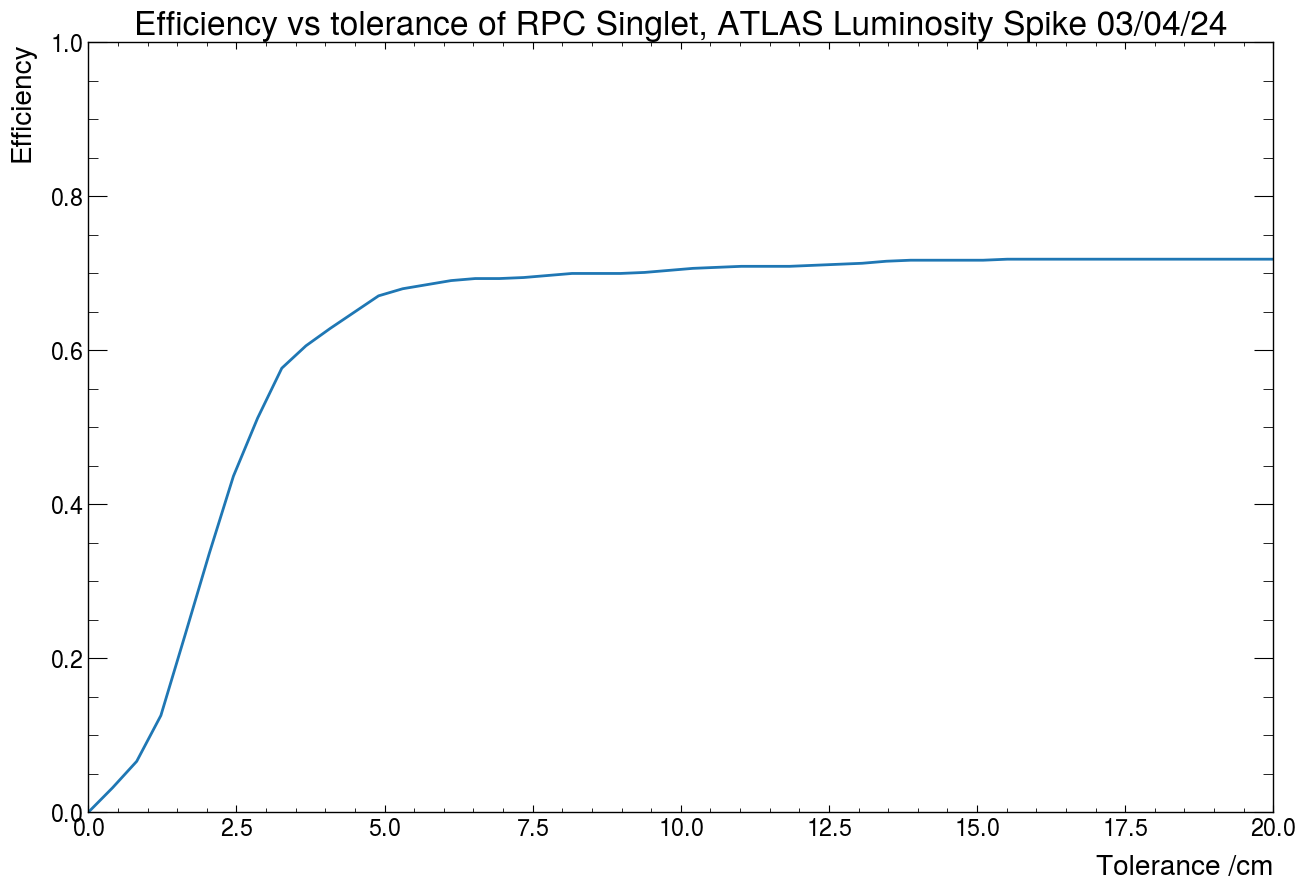

In [91]:
tolerances = np.linspace(0,20,50)

efficiencies4 = []

for tol in tolerances:
    print(tol)
    efficiencies4.append(calc_efficiency_RPC(coincident_hits_ATLAS_clustered,3,tol))

# Zip the nested lists together
toWrite = zip(efficiencies4, tolerances)

with open('Singlet.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerows(toWrite)

plt.figure(figsize=(15,10))

plt.plot(tolerances, efficiencies4)
plt.xlabel('Tolerance /cm')
plt.ylabel('Efficiency')
plt.ylim(0,1)

plt.title('Efficiency vs tolerance of RPC Singlet, ATLAS Luminosity Spike 03/04/24')

plt.show()

0.0
1194
0
0.40816326530612246
1194
54
0.8163265306122449
1194
140
1.2244897959183674
1194
184
1.6326530612244898
1194
273
2.0408163265306123
1194
339
2.4489795918367347
1194
386
2.857142857142857
1194
418
3.2653061224489797
1194
443
3.673469387755102
1194
465
4.081632653061225
1194
475
4.4897959183673475
1194
482
4.8979591836734695
1194
482
5.3061224489795915
1194
482
5.714285714285714
1194
484
6.122448979591837
1194
485
6.530612244897959
1194
488
6.938775510204081
1194
490
7.346938775510204
1194
490
7.755102040816327
1194
491
8.16326530612245
1194
491
8.571428571428571
1194
492
8.979591836734695
1194
494
9.387755102040817
1194
497
9.795918367346939
1194
498
10.204081632653061
1194
500
10.612244897959183
1194
500
11.020408163265307
1194
500
11.428571428571429
1194
500
11.83673469387755
1194
501
12.244897959183675
1194
501
12.653061224489797
1194
501
13.061224489795919
1194
501
13.46938775510204
1194
501
13.877551020408163
1194
502
14.285714285714286
1194
502
14.693877551020408
1194
50

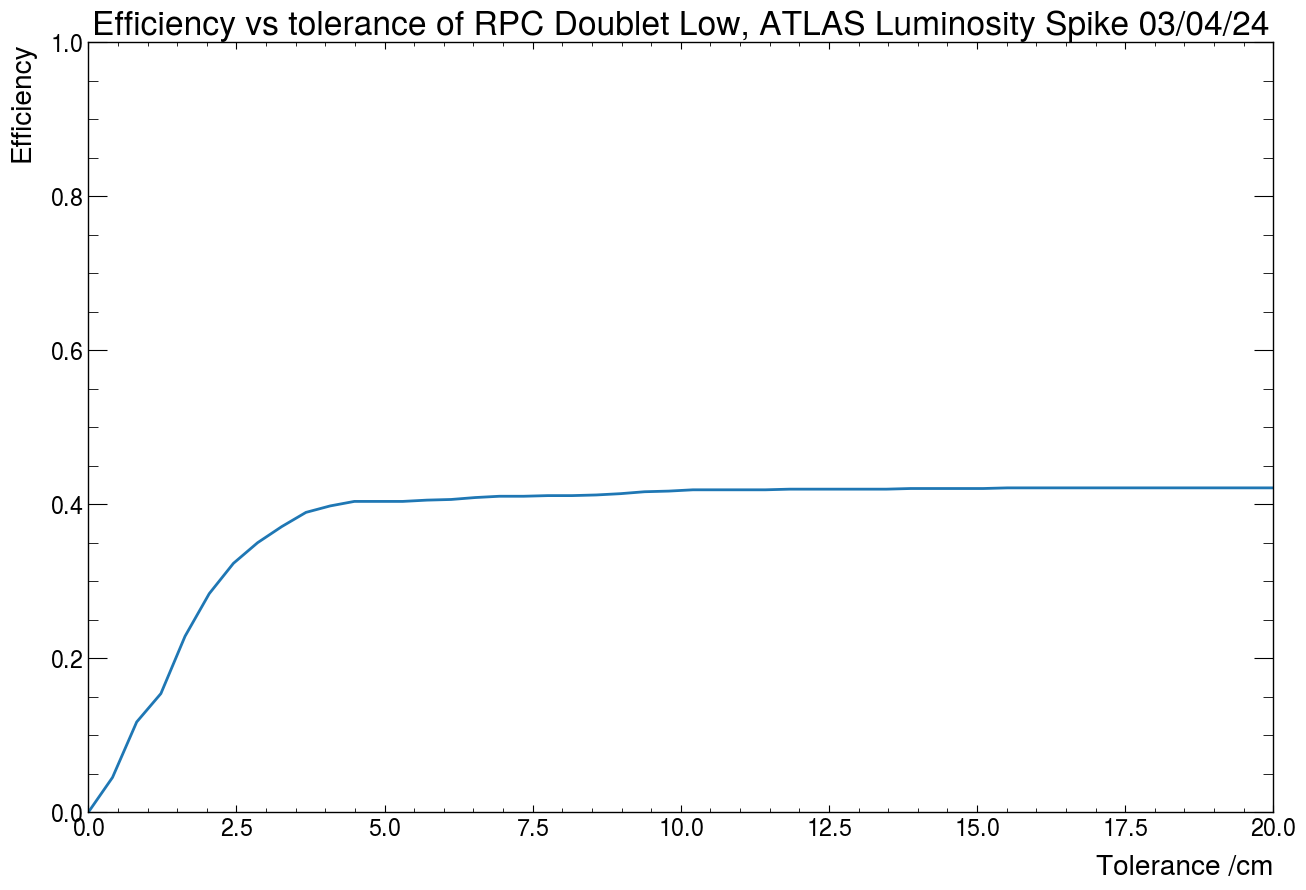

In [92]:
tolerances = np.linspace(0,20,50)

efficiencies5 = []

for tol in tolerances:
    print(tol)
    efficiencies5.append(calc_efficiency_RPC(coincident_hits_ATLAS_clustered,4,tol))

# Zip the nested lists together
toWrite = zip(efficiencies5, tolerances)

with open('DoubletLow.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerows(toWrite)

plt.figure(figsize=(15,10))

plt.plot(tolerances, efficiencies5)
plt.xlabel('Tolerance /cm')
plt.ylabel('Efficiency')
plt.ylim(0,1)

plt.title('Efficiency vs tolerance of RPC Doublet Low, ATLAS Luminosity Spike 03/04/24')

plt.show()

0.0
1066
0
0.40816326530612246
1066
36
0.8163265306122449
1066
125
1.2244897959183674
1066
251
1.6326530612244898
1066
329
2.0408163265306123
1066
394
2.4489795918367347
1066
443
2.857142857142857
1066
467
3.2653061224489797
1066
476
3.673469387755102
1066
479
4.081632653061225
1066
481
4.4897959183673475
1066
483
4.8979591836734695
1066
485
5.3061224489795915
1066
486
5.714285714285714
1066
486
6.122448979591837
1066
487
6.530612244897959
1066
487
6.938775510204081
1066
489
7.346938775510204
1066
489
7.755102040816327
1066
492
8.16326530612245
1066
492
8.571428571428571
1066
493
8.979591836734695
1066
493
9.387755102040817
1066
494
9.795918367346939
1066
495
10.204081632653061
1066
495
10.612244897959183
1066
497
11.020408163265307
1066
498
11.428571428571429
1066
498
11.83673469387755
1066
499
12.244897959183675
1066
499
12.653061224489797
1066
500
13.061224489795919
1066
501
13.46938775510204
1066
502
13.877551020408163
1066
503
14.285714285714286
1066
503
14.693877551020408
1066
50

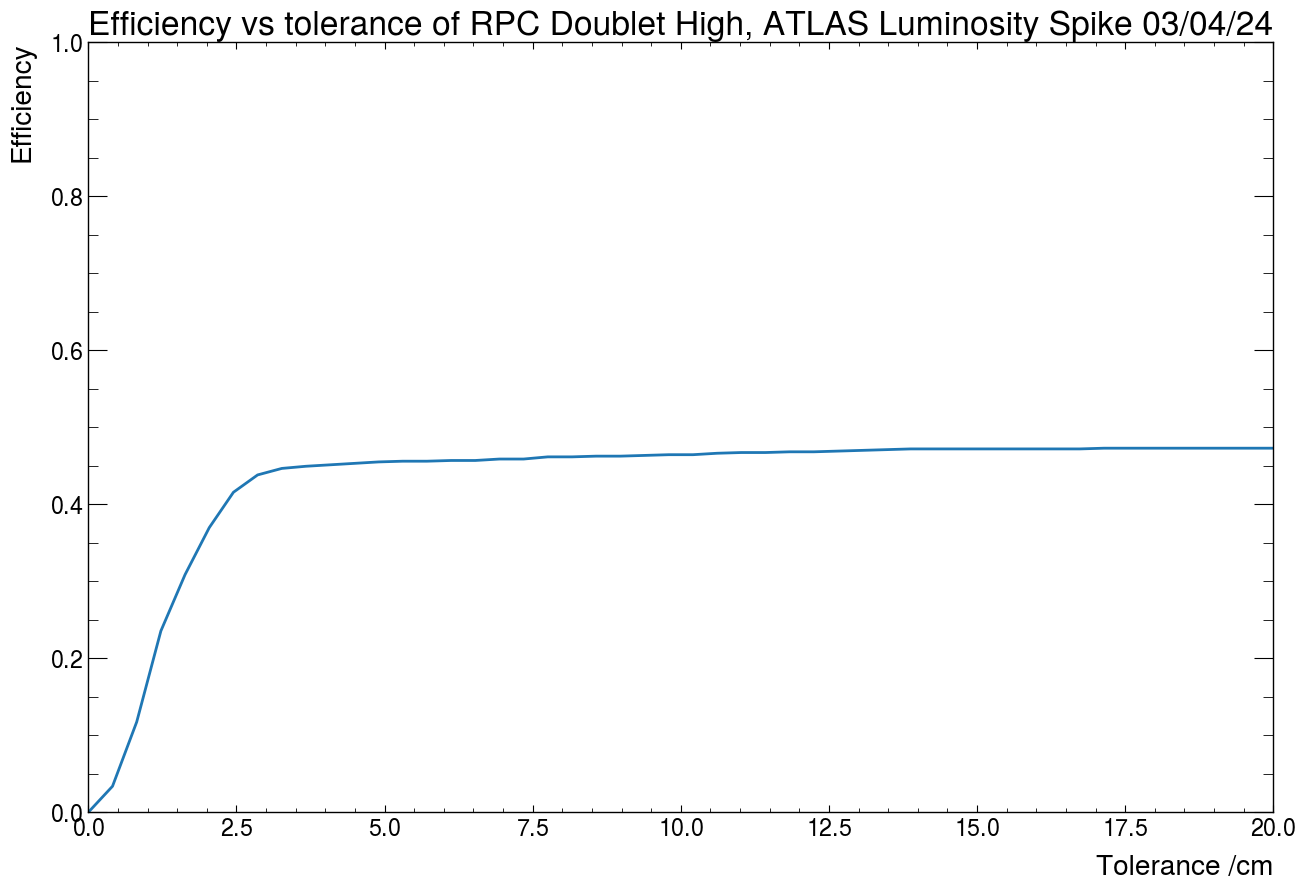

In [93]:
tolerances = np.linspace(0,20,50)

efficiencies6 = []

for tol in tolerances:
    print(tol)
    efficiencies6.append(calc_efficiency_RPC(coincident_hits_ATLAS_clustered,5,tol))

# Zip the nested lists together
toWrite = zip(efficiencies6, tolerances)

with open('DoubletTop.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerows(toWrite)

plt.figure(figsize=(15,10))

plt.plot(tolerances, efficiencies6)
plt.xlabel('Tolerance /cm')
plt.ylabel('Efficiency')
plt.ylim(0,1)

plt.title('Efficiency vs tolerance of RPC Doublet High, ATLAS Luminosity Spike 03/04/24')

plt.show()

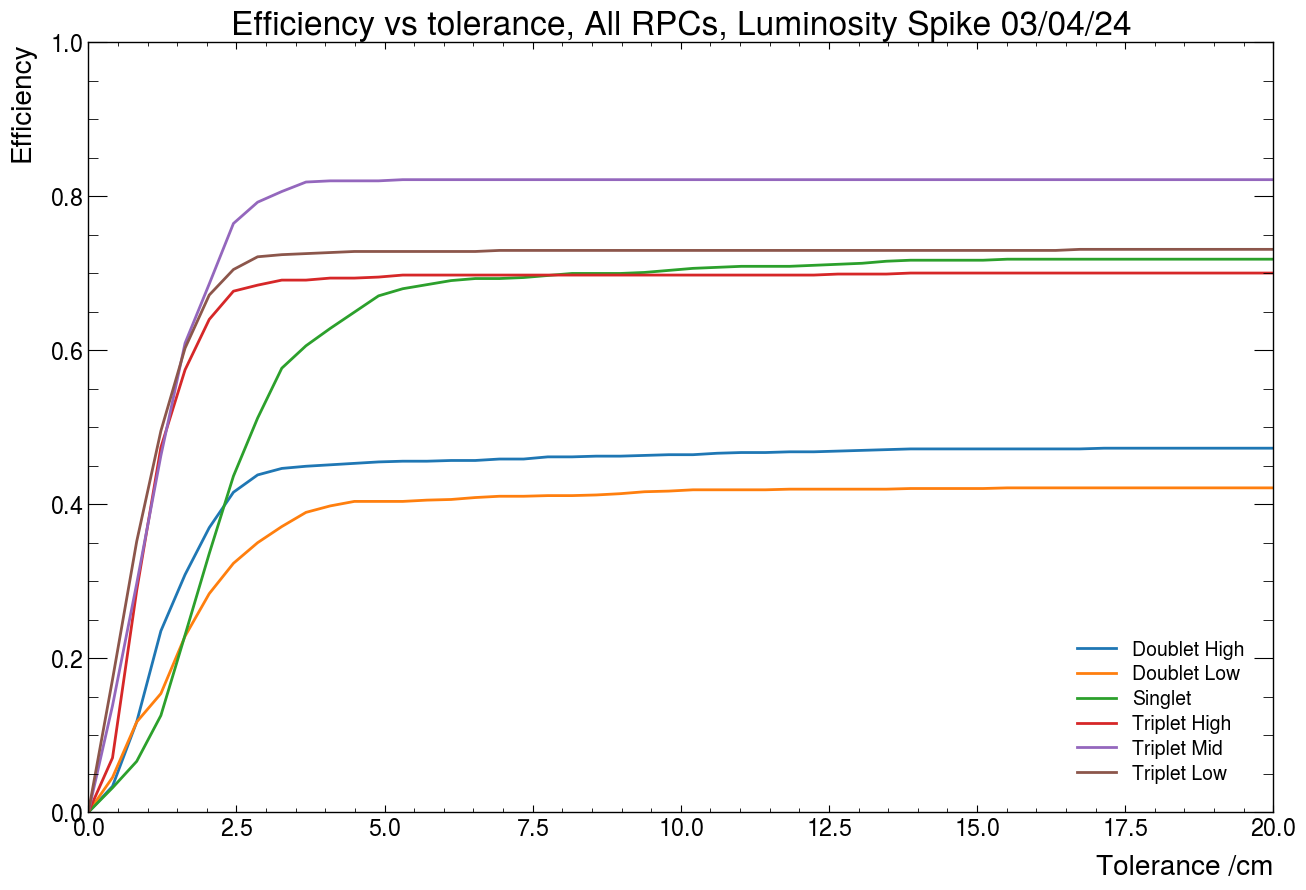

In [112]:
plt.figure(figsize=(15,10))

plt.plot(tolerances, efficiencies6, label= 'Doublet High')
plt.plot(tolerances, efficiencies5, label= 'Doublet Low')
plt.plot(tolerances, efficiencies4, label= 'Singlet')
plt.plot(tolerances, efficiencies3, label= 'Triplet High')
plt.plot(tolerances, efficiencies2, label= 'Triplet Mid')
plt.plot(tolerances, efficiencies1, label= 'Triplet Low')
plt.xlabel('Tolerance /cm')
plt.ylabel('Efficiency')

plt.legend()
plt.ylim(0,1)

plt.title('Efficiency vs tolerance, All RPCs, Luminosity Spike 03/04/24')

plt.show()

In [ ]:
def makeHitMaps(filenames, plotTitle, useJson=True, unit='khz', time=60.):
    if(useJson):
        hitData = {}
    
        addresses = ['ee00','ee01','ee02','ee03','ee04']
        for fname in filenames:
            thisFile = open(fname)
            jsonData = json.load(thisFile)
            for addr in addresses:
                try:
                    hitData[addr]=jsonData['Summary']['TDCs'][addr]['nHits']
                except KeyError:
                    continue
        for addr in addresses:
            if addr not in hitData.keys():
                hitData[addr] = [0 for x in range(128)]
            else:
                for idx, hit in enumerate(hitData[addr]):
                    hitData[addr][idx]= hit/1000. #Divide by 1000 to convert to khz
    else:
        hitData = filenames
    tripEtaLow = hitData['ee00'][0:32]
    tripPhiLow = hitData['ee00'][32:96]
    tripEtaMid = hitData['ee00'][96:128]
    tripPhiMid = hitData['ee01'][0:64]
    tripEtaTop = hitData['ee01'][64:96]
    tripPhiTop = hitData['ee01'][96:128]+hitData['ee02'][0:32]
    singEta = hitData['ee02'][32:64]
    singPhi = hitData['ee02'][64:128]
    doubEtaLow = hitData['ee03'][0:32]
    doubPhiLow = hitData['ee03'][32:96]
    doubEtaTop = hitData['ee03'][96:128]
    doubPhiTop = hitData['ee04'][0:64]
    imageArr = []
    imageArr.append(plotPhi(tripPhiLow,"Phi Triplet Low "+plotTitle, unit=unit, time=time))
    imageArr.append(plotEta(tripEtaLow,"Eta Triplet Low "+plotTitle, unit=unit, time=time))
    imageArr.append(plotPhi(tripPhiMid,"Phi Triplet Mid "+plotTitle, unit=unit, time=time))
    imageArr.append(plotEta(tripEtaMid,"Eta Triplet Mid "+plotTitle, unit=unit, time=time))
    imageArr.append(plotPhi(tripPhiTop,"Phi Triplet Top "+plotTitle, unit=unit, time=time))
    imageArr.append(plotEta(tripEtaTop,"Eta Triplet Top "+plotTitle, unit=unit, time=time))
    imageArr.append(plotPhi(singPhi,"Phi Singlet "+plotTitle, unit=unit, time=time))
    imageArr.append(plotEta(singEta,"Eta Singlet "+plotTitle, unit=unit, time=time))
    imageArr.append(plotPhi(doubPhiLow,"Phi Doublet Low "+plotTitle, unit=unit, time=time))
    imageArr.append(plotEta(doubEtaLow,"Eta Doublet Low "+plotTitle, unit=unit, time=time))
    imageArr.append(plotPhi(doubPhiTop,"Phi Doublet Top "+plotTitle, unit=unit, time=time))
    imageArr.append(plotEta(doubEtaTop,"Eta Doublet Top "+plotTitle, unit=unit, time=time))
    combinePlots(imageArr,plotTitle)
    for im in imageArr:
        os.remove(im)

In [118]:

def plotPhi(array, name, zrange = [0.01,200], unit='khz', time=60.):
    fig, ax = plt.subplots(1, figsize=(16, 8), dpi=100)
    phichannels = [x-0.5 for x in range(65)]
    phiHist = ((np.array([array])/time).transpose(),np.array(phichannels),np.array([0,1]))
    thisHist = hep.hist2dplot(phiHist,norm=colors.LogNorm(zrange[0],zrange[1]))
    thisHist.cbar.set_label('Event Rate ('+unit+')', rotation=270, loc='center')
    plt.xlabel("Channel")
    plt.ylabel(" ")
    plt.title(name)
    fig.tight_layout()
    ax.get_yaxis().set_visible(False)
    plt.savefig(current_directory+"\\Figures\\"+name.strip(" ")+".png")
    return current_directory+"\\Figures\\"+name.strip(" ")+".png"

def plotEta(array, name, zrange = [0.01,200], unit='khz', time=60.):
    fig, ax = plt.subplots(1, figsize=(16, 8), dpi=100)
    etachannels = [x-0.5 for x in range(33)]
    etaHist = (np.array([array])/time,np.array([0,1]),np.array(etachannels))
    thisHist = hep.hist2dplot(etaHist,norm=colors.LogNorm(zrange[0],zrange[1]))
    thisHist.cbar.set_label('Event Rate ('+unit+')', rotation=270, loc='center')
    plt.ylim(31.5,-0.5)
    plt.ylabel("Channel")
    plt.xlabel(" ")
    plt.title(name)
    fig.tight_layout()
    ax.get_xaxis().set_visible(False)
    plt.savefig(current_directory+"\\Figures\\"+name.strip(" ")+".png")
    return current_directory+"\\Figures\\"+name.strip(" ")+".png"

def combinePlots(plots,imname):
    images = [Image.open(x) for x in plots]
    widths, heights = zip(*(i.size for i in images))

    total_width = int(2*widths[0])
    if(len(plots)|2>0):
        max_height = int((sum(heights)+heights[0])/2)
    else:
        max_height = int(sum(heights)/2)

    new_im = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    y_offset = 0
    even = True
    for im in images:
        if even:
            new_im.paste(im, (x_offset,y_offset))
            x_offset += im.size[0]
            even = False
        else:
            new_im.paste(im,(x_offset,y_offset))
            x_offset = 0
            y_offset += im.size[1]
            even = True

    new_im.save(imname.strip(" ")+'.pdf')
    
def makeHitMaps(filenames, plotTitle, useJson=True, unit='khz', time=60.):
    if(useJson):
        hitData = {}
    
        addresses = ['ee00','ee01','ee02','ee03','ee04']
        for fname in filenames:
            thisFile = open(fname)
            jsonData = json.load(thisFile)
            for addr in addresses:
                try:
                    hitData[addr]=jsonData['Summary']['TDCs'][addr]['nHits']
                except KeyError:
                    continue
        for addr in addresses:
            if addr not in hitData.keys():
                hitData[addr] = [0 for x in range(128)]
            else:
                for idx, hit in enumerate(hitData[addr]):
                    hitData[addr][idx]= hit/1000. #Divide by 1000 to convert to khz
    else:
        hitData = filenames
    tripEtaLow = hitData['ee00'][0:32]
    tripPhiLow = hitData['ee00'][32:96]
    tripEtaMid = hitData['ee00'][96:128]
    tripPhiMid = hitData['ee01'][0:64]
    tripEtaTop = hitData['ee01'][64:96]
    tripPhiTop = hitData['ee01'][96:128]+hitData['ee02'][0:32]
    singEta = hitData['ee02'][32:64]
    singPhi = hitData['ee02'][64:128]
    doubEtaLow = hitData['ee03'][0:32]
    doubPhiLow = hitData['ee03'][32:96]
    doubEtaTop = hitData['ee03'][96:128]
    doubPhiTop = hitData['ee04'][0:64]
    imageArr = []
    imageArr.append(plotPhi(tripPhiLow,"Phi Triplet Low "+plotTitle, unit=unit, time=time))
    imageArr.append(plotEta(tripEtaLow,"Eta Triplet Low "+plotTitle, unit=unit, time=time))
    imageArr.append(plotPhi(tripPhiMid,"Phi Triplet Mid "+plotTitle, unit=unit, time=time))
    imageArr.append(plotEta(tripEtaMid,"Eta Triplet Mid "+plotTitle, unit=unit, time=time))
    imageArr.append(plotPhi(tripPhiTop,"Phi Triplet Top "+plotTitle, unit=unit, time=time))
    imageArr.append(plotEta(tripEtaTop,"Eta Triplet Top "+plotTitle, unit=unit, time=time))
    imageArr.append(plotPhi(singPhi,"Phi Singlet "+plotTitle, unit=unit, time=time))
    imageArr.append(plotEta(singEta,"Eta Singlet "+plotTitle, unit=unit, time=time))
    imageArr.append(plotPhi(doubPhiLow,"Phi Doublet Low "+plotTitle, unit=unit, time=time))
    imageArr.append(plotEta(doubEtaLow,"Eta Doublet Low "+plotTitle, unit=unit, time=time))
    imageArr.append(plotPhi(doubPhiTop,"Phi Doublet Top "+plotTitle, unit=unit, time=time))
    imageArr.append(plotEta(doubEtaTop,"Eta Doublet Top "+plotTitle, unit=unit, time=time))
    combinePlots(imageArr,plotTitle)
    for im in imageArr:
        os.remove(im)

def heatFromFile(dataFile, time=240, name="HeatMap"):
    #MR
    #Plots heat maps from triggered data, showing the hit rate in each rpc channel. 2D plots designed to replicate RPC layout and channel counting direction.
    thisData = ANT.importDatafile(dataFile)
    thisHitData = {}
    addresses = ['ee00','ee01','ee02','ee03','ee04']
    for tdc in range(5):
        thisHitData[addresses[tdc]] = ANT.countChannels(thisData[tdc])
    makeHitMaps(thisHitData,name,False,unit='hz',time=time)

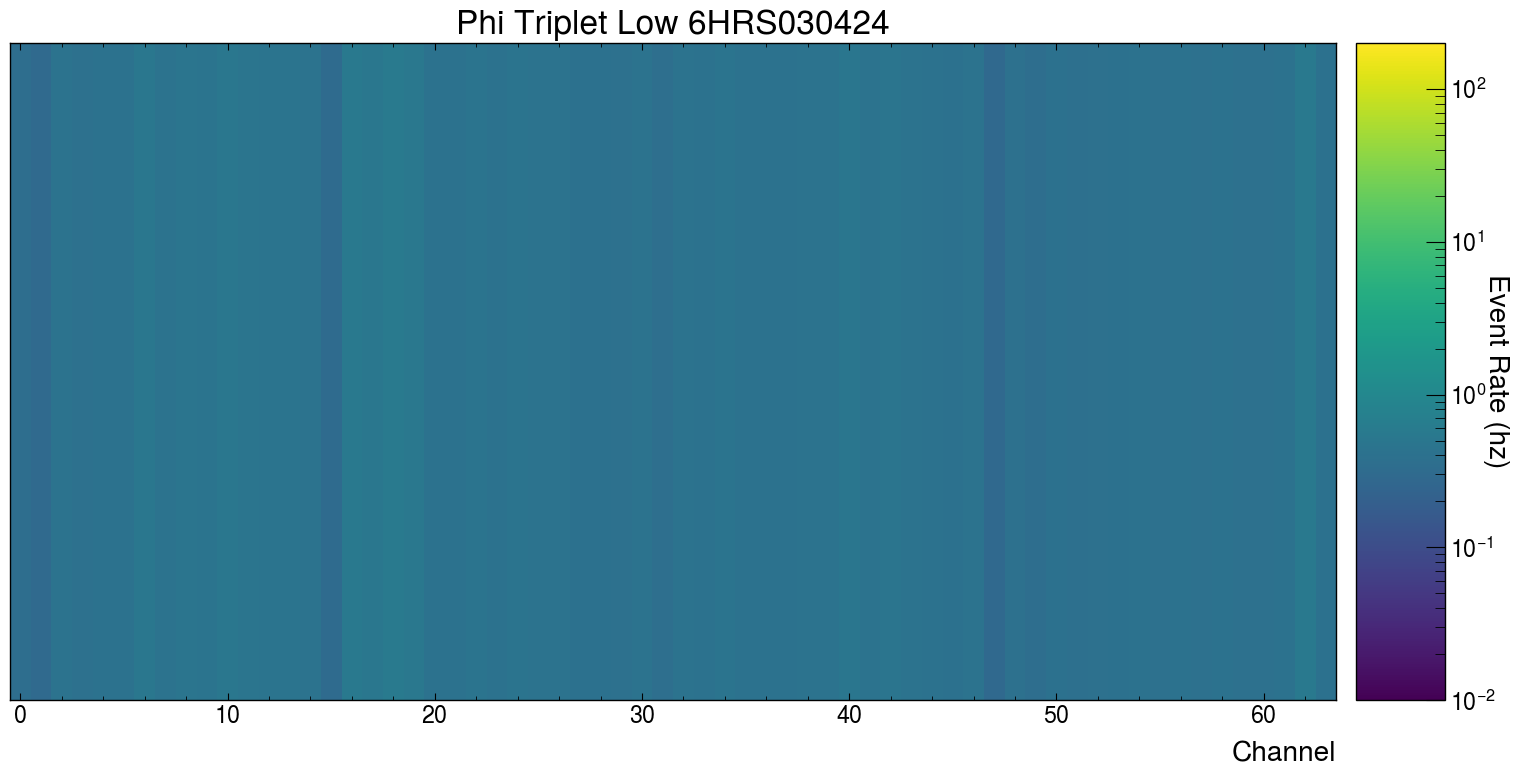

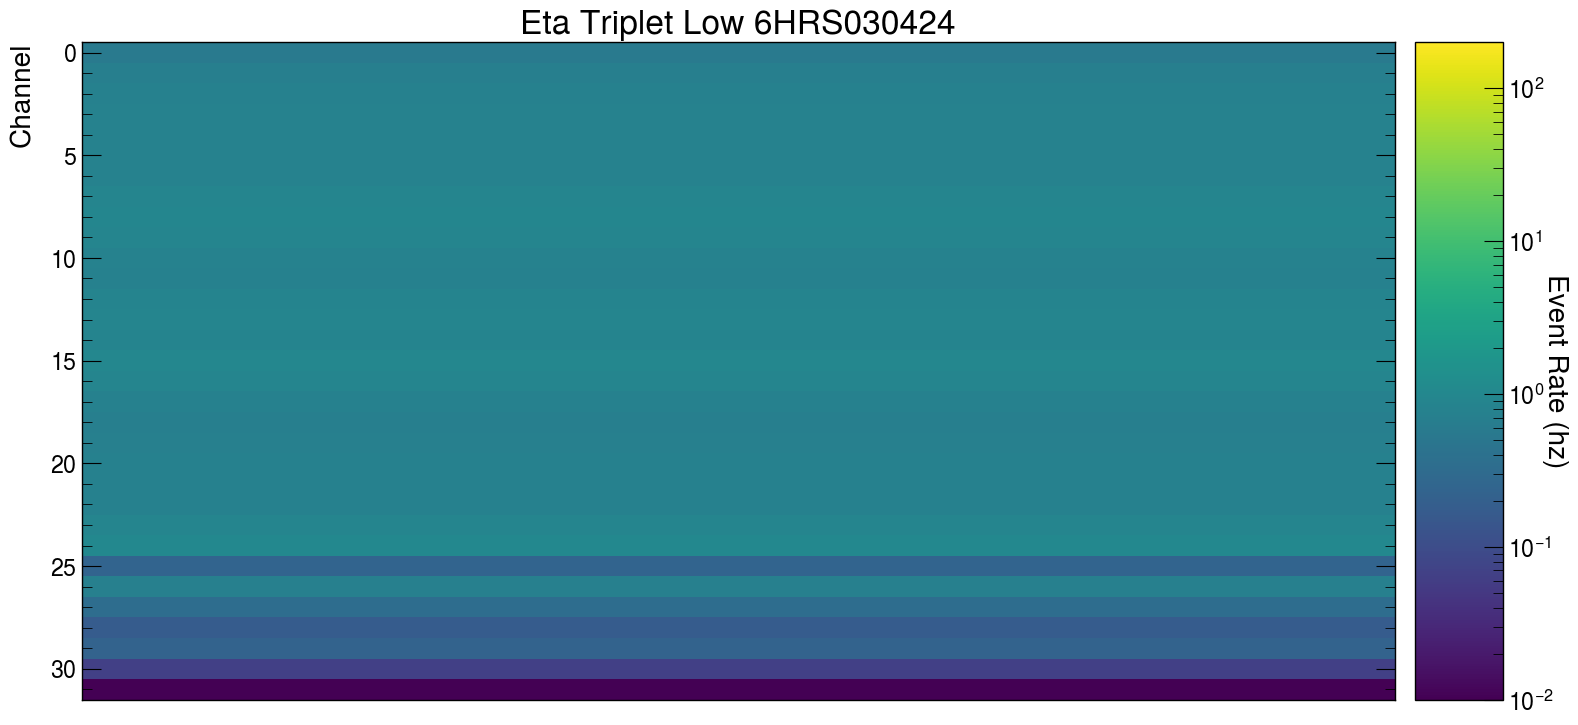

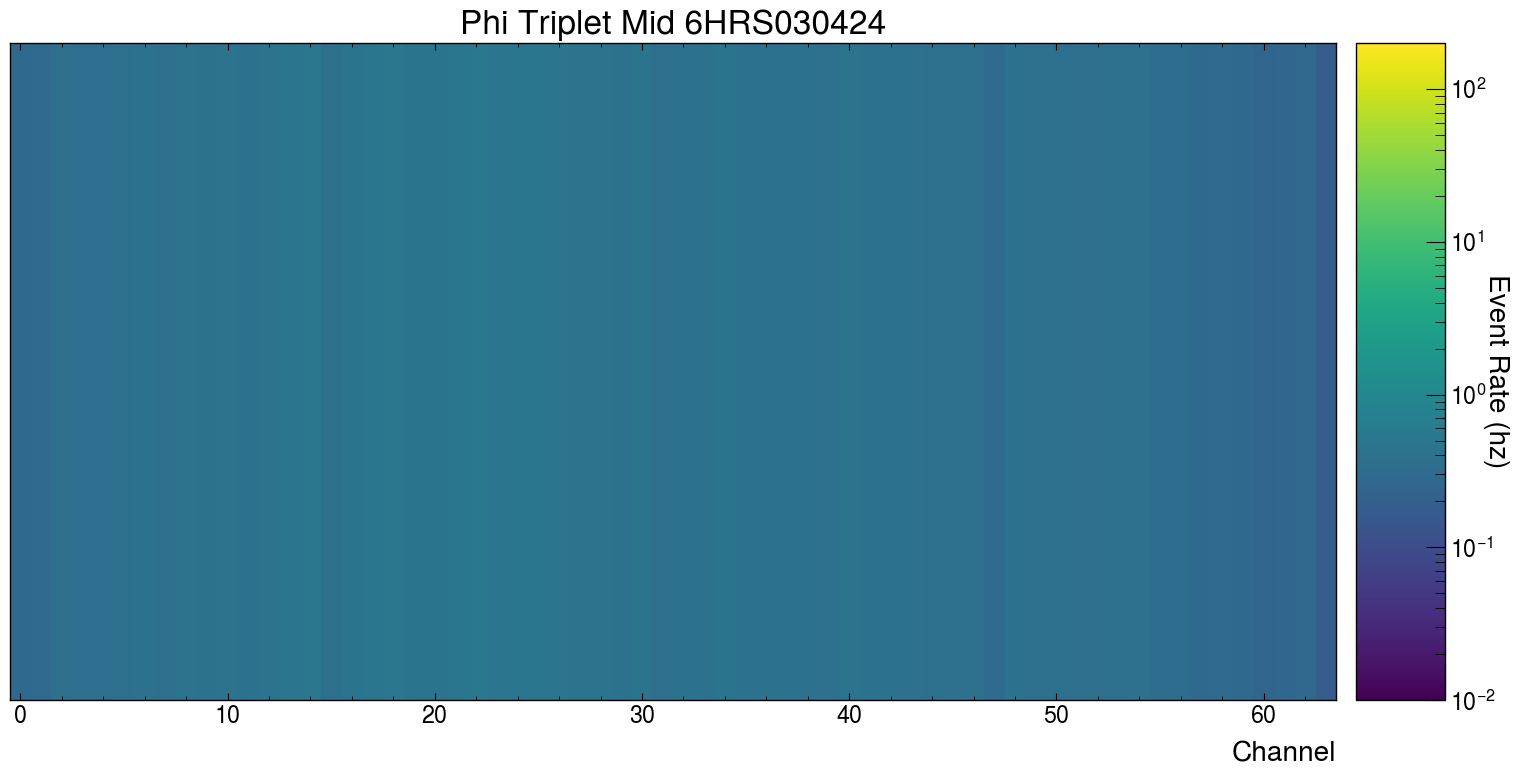

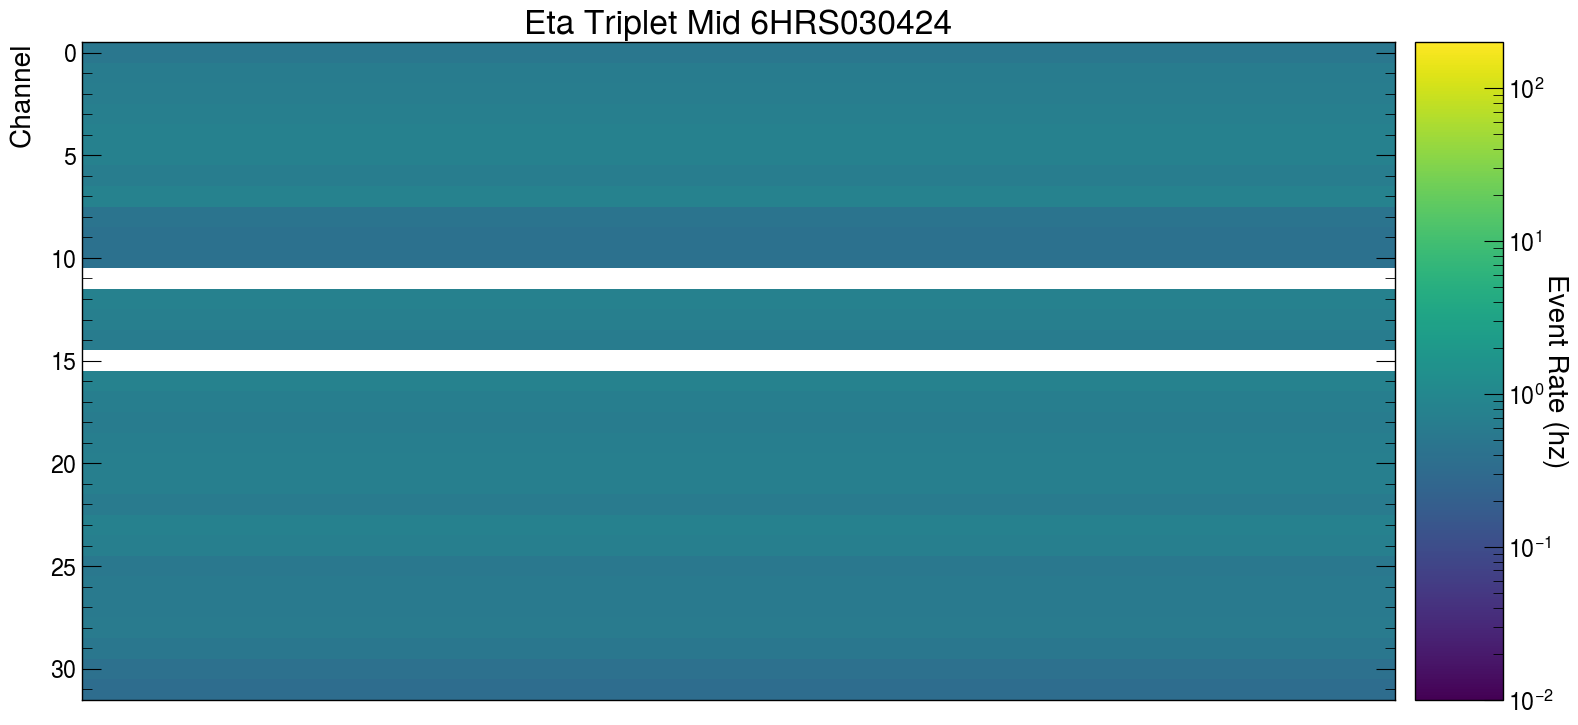

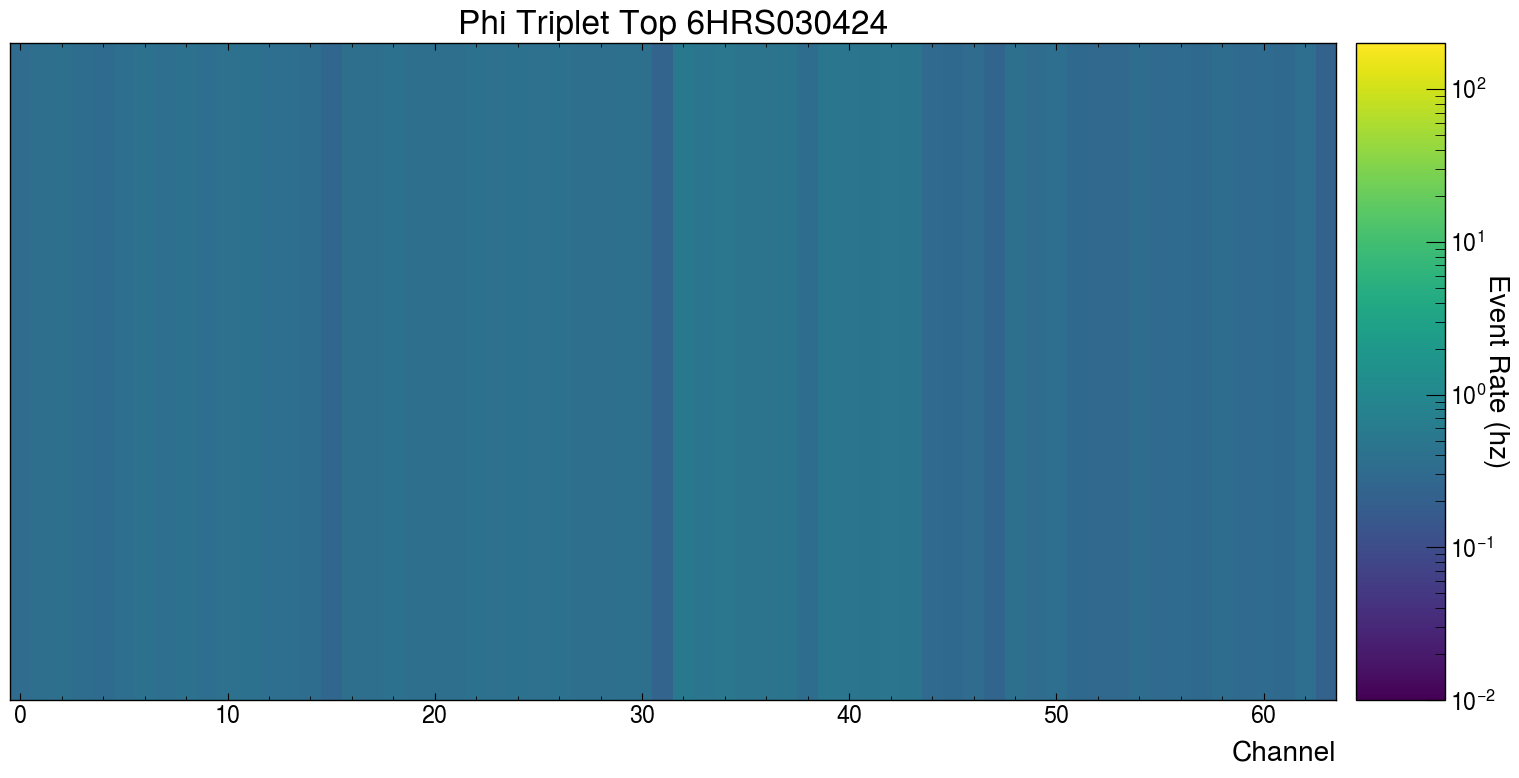

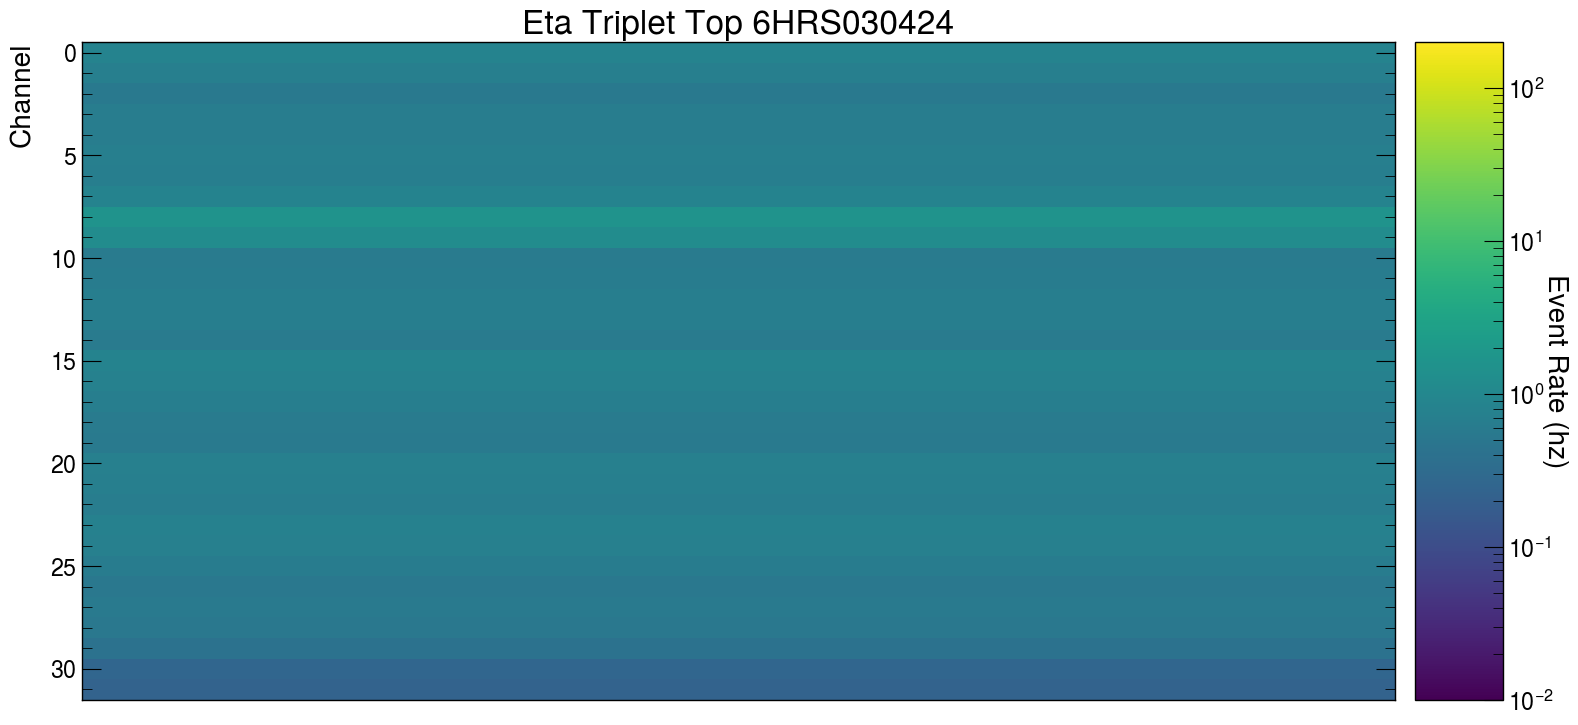

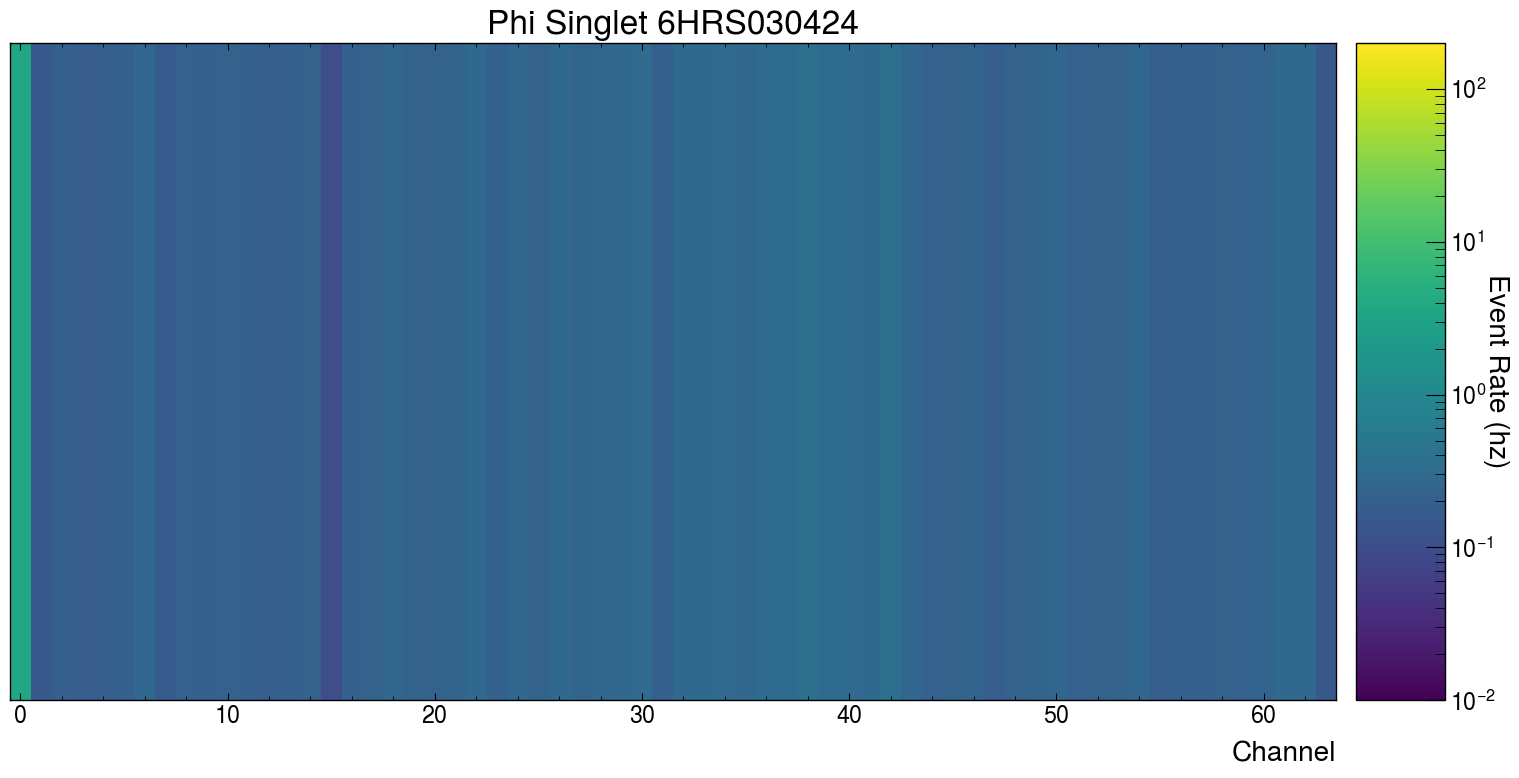

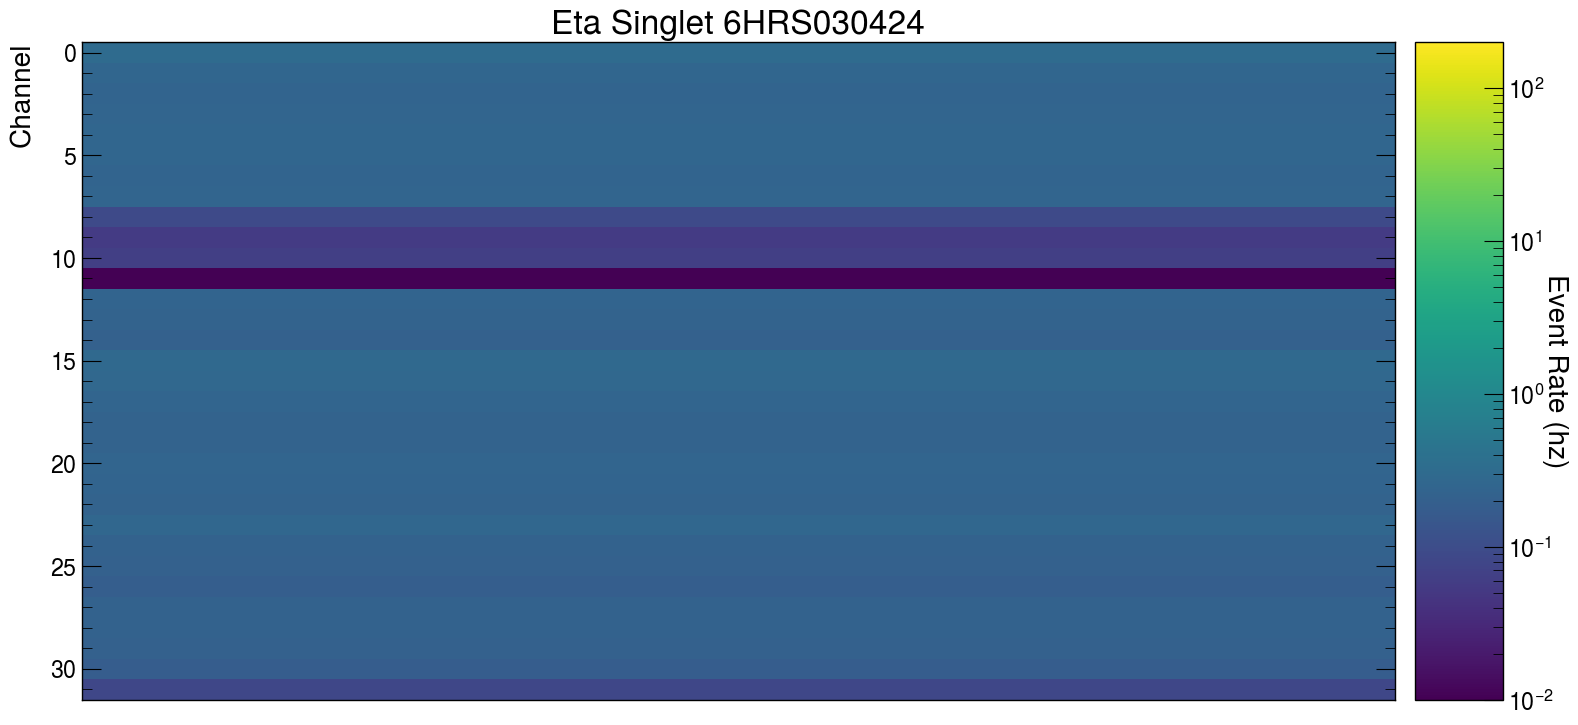

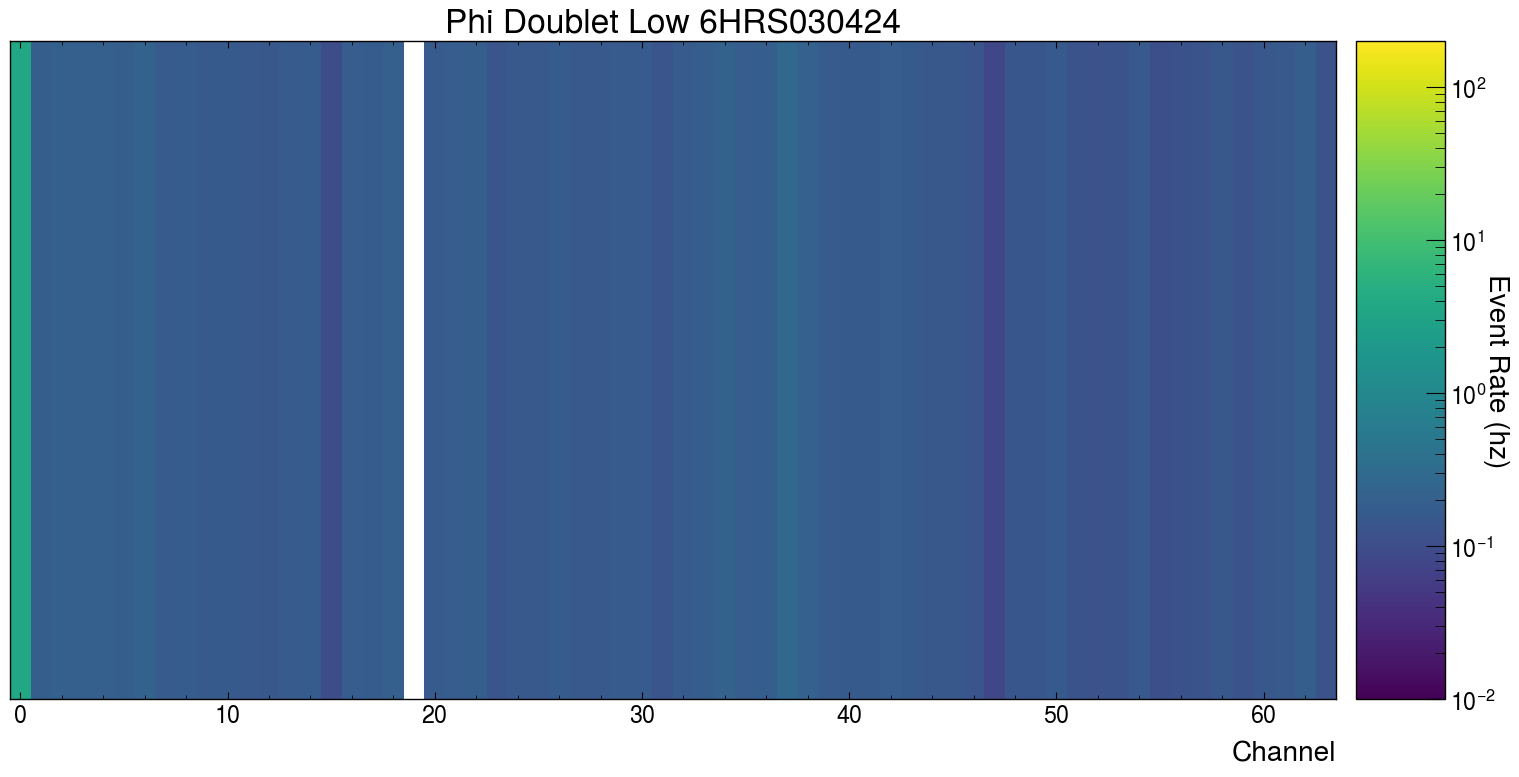

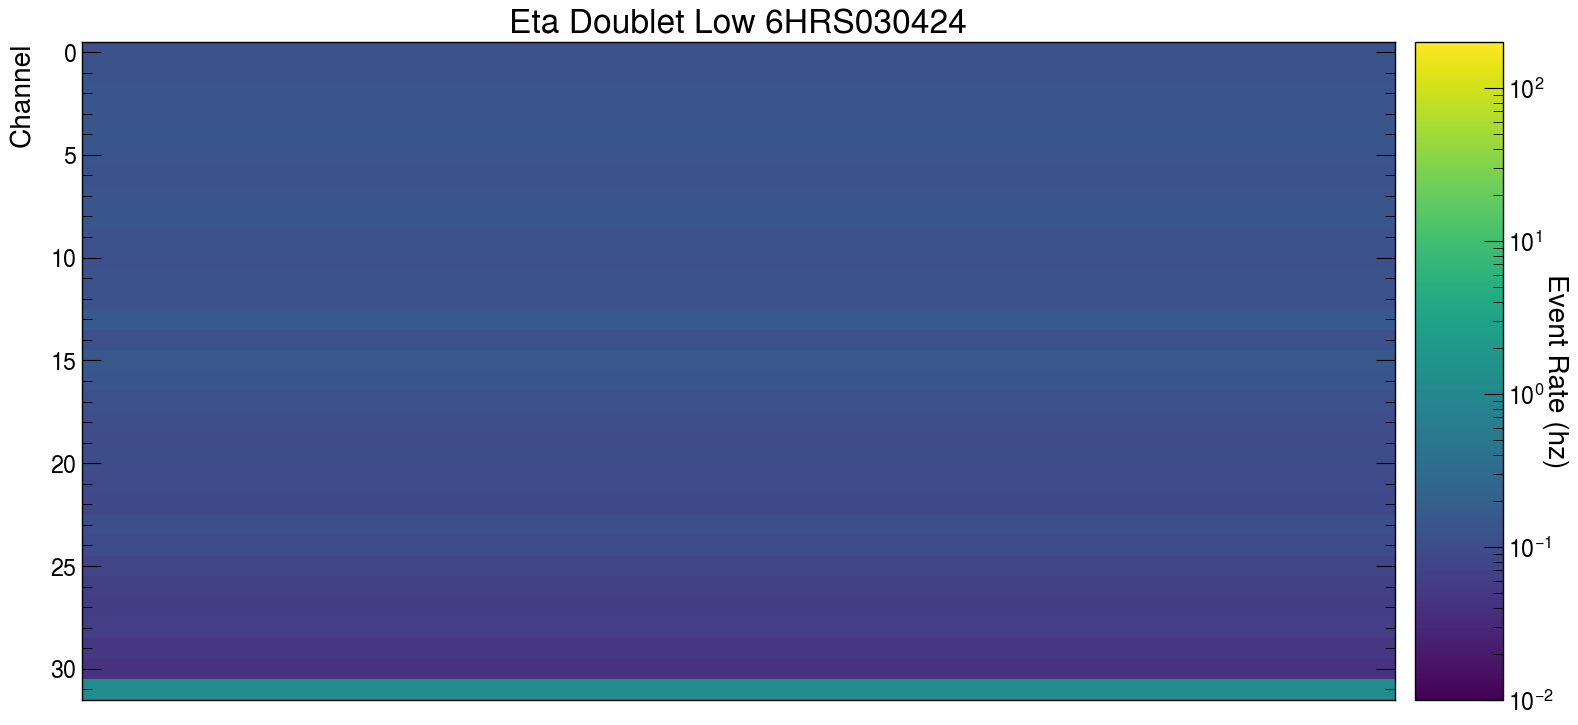

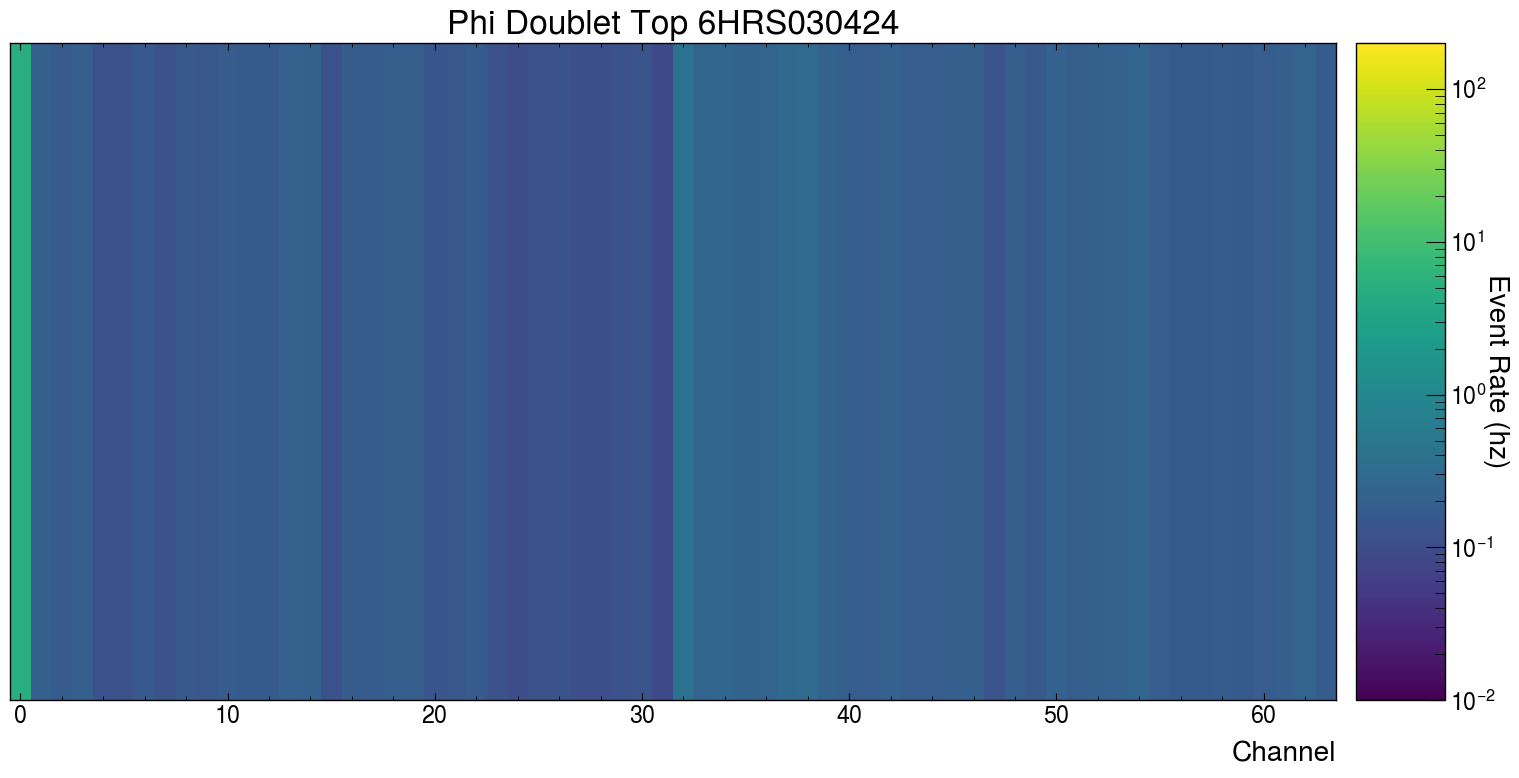

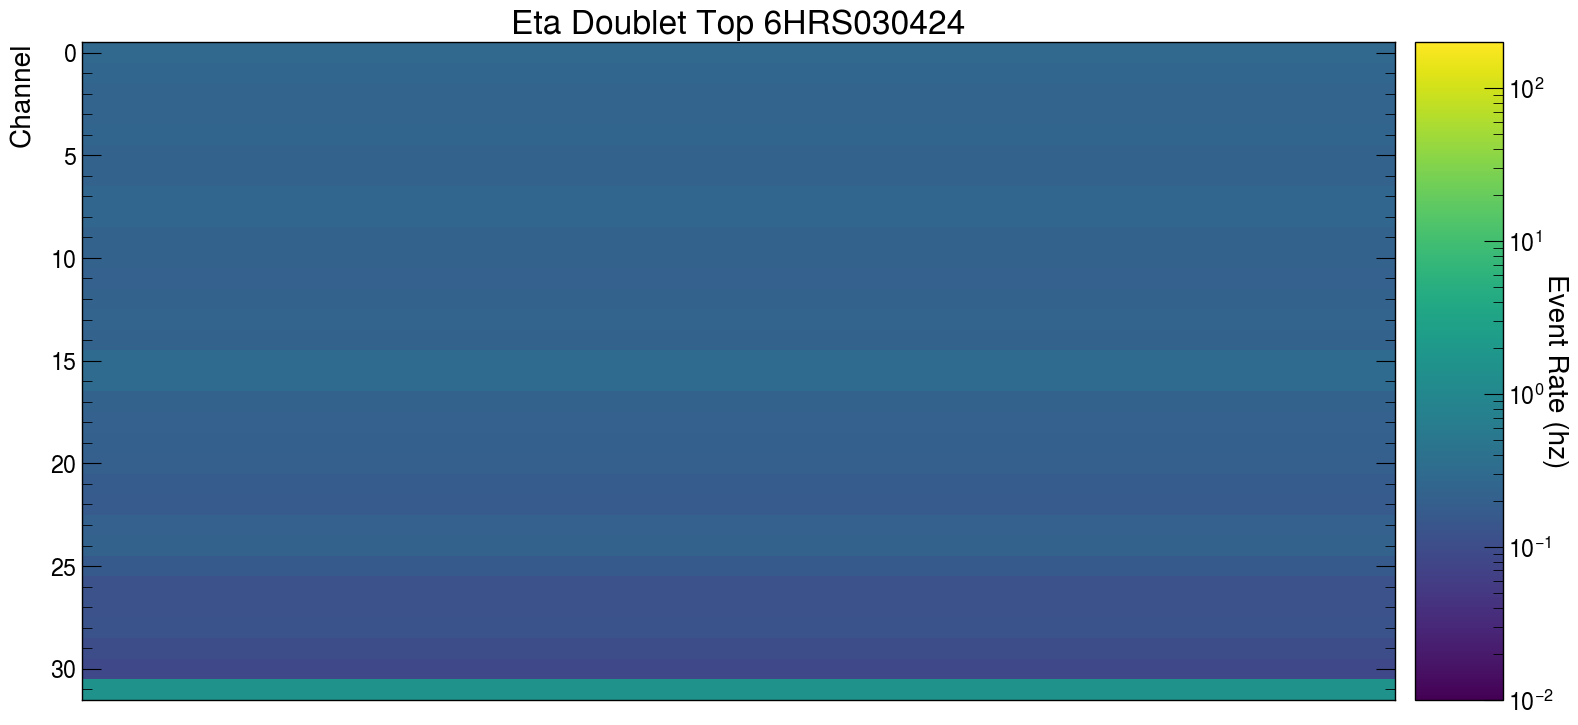

In [120]:
heatFromFile(current_directory+"\\ProAnubisData\\ATLAS LUMINOSITY\\proAnubis_240403_0227.h5",21600,"6HRS030424")

Cosmics Data from 03/04/24

In [ ]:
Cosmics = ANT.importFromHDF5File(current_directory+"\\ProAnubisData\\ATLAS LUMINOSITY\\proAnubis_240403_1427_cosmics.h5")

data_cosmics = [sublist[:83169] for sublist in Cosmics]

c_etaHits, c_phiHits = divideHitCountsByRPC_Timed_UNCORRUPTED(data_cosmics)

#Time_window for coincidence set at 15 ns.
#Temporal Clustering
coincident_hits_cosmics = ANT.FindCoincidentHits(c_etaHits,c_phiHits,15)

#Spatial Clustering
coincident_hits_cosmics_clustered = ANT.cluster(coincident_hits_cosmics)

print(len(coincident_hits_cosmics_clustered))